In [1]:
println("Start_Partile Filtering ....")

# add necessary Packages
#import Pkg;
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("Distributions")
#Pkg.add("Plots")
#Pkg.add("LinearAlgebra")
#Pkg.add("MKL")
#Pkg.add("BenchmarkTools")
# include ncecssary Packages
using Plots, CSV, DataFrames, Distributions, MKL, LinearAlgebra, BenchmarkTools

Start_Partile Filtering ....


In [2]:
# read data

# year 2009
data_k1_1 = CSV.read("data_k1_1.csv", DataFrame);
data_k2_1 = CSV.read("data_k2_1.csv", DataFrame);
data_k3_1 = CSV.read("data_k3_1.csv", DataFrame);

# year 2010
data_k1_2 = CSV.read("data_k1_2.csv", DataFrame);
data_k2_2 = CSV.read("data_k2_2.csv", DataFrame);
data_k3_2 = CSV.read("data_k3_2.csv", DataFrame);

# year 2011
data_k1_3 = CSV.read("data_k1_3.csv", DataFrame);
data_k2_3 = CSV.read("data_k2_3.csv", DataFrame);
data_k3_3 = CSV.read("data_k3_3.csv", DataFrame);

data_k1_1 = Matrix(data_k1_1);
data_k2_1 = Matrix(data_k2_1);
data_k3_1 = Matrix(data_k3_1);

data_k1_2 = Matrix(data_k1_2);
data_k2_2 = Matrix(data_k2_2);
data_k3_2 = Matrix(data_k3_2);

data_k1_3 = Matrix(data_k1_3);
data_k2_3 = Matrix(data_k2_3);
data_k3_3 = Matrix(data_k3_3);

(s_k1_1_d1, s_k1_1_d2) = size(data_k1_1);
(s_k2_1_d1, s_k2_1_d2) = size(data_k2_1);
(s_k3_1_d1, s_k3_1_d2) = size(data_k3_1);

(s_k1_2_d1, s_k1_2_d2) = size(data_k1_2);
(s_k2_2_d1, s_k2_2_d2) = size(data_k2_2);
(s_k3_2_d1, s_k3_2_d2) = size(data_k3_2);

(s_k1_3_d1, s_k1_3_d2) = size(data_k1_3);
(s_k2_3_d1, s_k2_3_d2) = size(data_k2_3);
(s_k3_3_d1, s_k3_3_d2) = size(data_k3_3);

In [5]:
# miscellaneous -- setup

nS            = 100;    # number of simulated pseudo-factors to draw   

scale         = 100000;
converged     = 0; 
converged_t   = 0;   
yr            = 1;
case_k        = 3;
max_s         = 2*scale; # to be revised. 
max_iter      = 100; #default 100000 
tol           = 0.1/nS;  # tolerance criteria   
n_sim         = 10;

In [6]:
# dimension setup

nK       = 3;     
n_yr     = 3;          # yr1 = 98; yr2 = 99; yr3 = 100;  

# parameters (heterogeneity in doctor's altruism)

chi_mu1       = 5;        # disutility toward overdoing (mean)
chi_mu2       = 5;        # disutility toward underdoing (mean)
chi_sigma1    = 0.2;      # disutility toward overdoing (variance)
chi_sigma2    = 0.2;      # disutility toward underdoing (variance)  

delta0_u      = 10;
delta0_d      = 10;       # if small, k=1 when k_o=2 for all; very sensitive 

#cost          = 0.73; 
#r_ub          = 0.8; 
Min_pay       = 1.0/scale;    
Fix_pay3_2009 = 128986/scale;

In [7]:
# setting up global
const cost     = 0.73;
const r_ub     = 0.8; 
const Q        = [10868.0/scale 10868.0/scale 8918.0/scale; 47060.0/scale 47060.0/scale 38177.0/scale; 52560.0/scale 52560.0/scale 42513.0/scale];
const C0       = [Q[1,1]*0.75 Q[1,2]*0.75 Q[1,3]*0.75;Q[2,1]*0.75 Q[2,2]*0.75 Q[2,3]*0.75;Q[3,1]*0.75 Q[3,2]*0.75 Q[3,3]*0.75];
const LB       = [45325.0/scale 45325.0/scale 45483.0/scale;45325.0/scale 45325.0/scale 45483.0/scale;92650.0/scale 92650.0/scale 92650.0/scale];
const UB       = [117566.0/scale 117566.0/scale 115930.0/scale;117566.0/scale 117566.0/scale 115930.0/scale;130935.0/scale 130935.0/scale 128986.0/scale];
const Fix_pay  = [91589.0/scale 91589.0/scale 89797.0/scale;91589.0/scale 91589.0/scale 89797.0/scale;130935.0/scale 130935.0/scale 128986.0/scale];


In [8]:
# setting up data

m_observed_data_yr1 = [data_k1_1.-Q[1 ,1]*scale ones(s_k1_1_d1,1) ones(s_k1_1_d1,1); data_k2_1.-Q[2 ,1]*scale 2*ones(s_k2_1_d1,1) ones(s_k2_1_d1,1); data_k3_1.-Q[3 ,1]*scale 3*ones(s_k3_1_d1,1) ones(s_k3_1_d1,1)];    
m_observed_yr1 = [data_k1_1 ones(s_k1_1_d1,1) ones(s_k1_1_d1,1); data_k2_1 2*ones(s_k2_1_d1,1) ones(s_k2_1_d1,1); data_k3_1 3*ones(s_k3_1_d1,1) ones(s_k3_1_d1,1)]; 
ssk_1 = s_k1_1_d1 + s_k2_1_d1 + s_k3_1_d1;

m_observed_data_yr2 = [data_k1_2.-Q[1 ,2]*scale ones(s_k1_2_d1,1) 2*ones(s_k1_2_d1,1); data_k2_2.-Q[2 ,2]*scale 2*ones(s_k2_2_d1,1) 2*ones(s_k2_2_d1,1); data_k3_2.-Q[3 ,2]*scale 3*ones(s_k3_2_d1,1) 2*ones(s_k3_2_d1,1)];  
m_observed_yr2 = [data_k1_2 ones(s_k1_2_d1,1) 2*ones(s_k1_2_d1,1); data_k2_2 2*ones(s_k2_2_d1,1) 2*ones(s_k2_2_d1,1); data_k3_2 3*ones(s_k3_2_d1,1) 2*ones(s_k3_2_d1,1)];  
ssk_2 = s_k1_2_d1 + s_k2_2_d1 + s_k3_2_d1;

m_observed_data_yr3 = [data_k1_3.-Q[1 ,3]*scale ones(s_k1_3_d1,1) 3*ones(s_k1_3_d1,1); data_k2_3.-Q[2 ,3]*scale 2*ones(s_k2_3_d1,1) 3*ones(s_k2_3_d1,1); data_k3_3.-Q[3 ,3]*scale 3*ones(s_k3_3_d1,1) 3*ones(s_k3_3_d1,1)]; 
m_observed_yr3 = [data_k1_3 ones(s_k1_3_d1,1) 3*ones(s_k1_3_d1,1); data_k2_3 2*ones(s_k2_3_d1,1) 3*ones(s_k2_3_d1,1); data_k3_3 3*ones(s_k3_3_d1,1) 3*ones(s_k3_3_d1,1)]; 
ssk_3 = s_k1_3_d1 + s_k2_3_d1 + s_k3_3_d1;

m_observed_all = [m_observed_data_yr1; m_observed_data_yr2; m_observed_data_yr3];
m_observed_true = [m_observed_yr1; m_observed_yr2; m_observed_yr3];
(num_obs, temp) = size(m_observed_all);

s = (m_observed_all[:,1])/scale;
k = m_observed_all[:,2]; 
year = m_observed_all[:,3]; 


In [9]:
# model initilization

fdensity       = zeros(num_obs,nS);

m_observed_trun = m_observed_true;

so_hat = max_s./scale*rand(1,nS)
ko_hat = floor.(Int,3*rand(1,nS) .+ 1);
g = (1/3) * (1/10) * ones(1,nS); #Density particles are drawn from;

temptrim  = findall(x-> x>max_s/scale,s); 
s[temptrim] .= max_s/scale; 
m_observed_trun[temptrim] .= max_s .+ Q[case_k ,yr]*scale;


In [10]:
# check graphs

#histogram(m_observed_trunnormalize =:probability)
#histogram(s,normalize =:probability)

In [11]:
# functions needed for calculating the density

function util_fnt(yr,ko,so,k,chi1,chi2,delta_u,delta_d)
    
    s = -100;
    
    if(so+Q[k,yr]<LB[k,yr])

        temp_bottom = (LB[k, yr] - Q[k,yr] - so);
        chi_A = (1-cost)/(2*temp_bottom); 
        chi_A = chi_A + (Fix_pay[k, yr]-LB[k, yr])/(2*temp_bottom^2);
        chi_A = chi_A + sqrt( (Fix_pay[k, yr]-LB[k, yr])^2 + 2*(Fix_pay[k, yr]-LB[k, yr])*(1-cost)*(LB[k, yr]-Q[k,yr]-so))/(2*temp_bottom^2);

        temp_top = r_ub*(UB[k, yr]-Q[k,yr]-so)-cost*(LB[k, yr]-Q[k,yr]-so);
        Atemp = temp_top^2-(r_ub-cost)^2*(LB[k,yr]-Q[k,yr]-so);
        temp_top = temp_top - (Atemp)^(0.5);
        chi_A2 = temp_top/(2*(LB[k, yr]-Q[k,yr]-so)^2);

        if(chi1 > chi_A)
            util = (1-cost)*so+(1-cost)^2/(4*chi1)+Q[k ,yr]-C0[k, yr];
            s = so + (1-cost)/(2*chi1);
        elseif(chi1 > chi_A2)
            util = Fix_pay[k,yr]-cost*(LB[k, yr]-Q[k ,yr])-chi1*(LB[k, yr]-Q[k ,yr]-so)^2-C0[k, yr];
            s = LB[k,yr] - Q[k,yr];
        else #chi1 <= chi_A2 
            util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];  
            s = so + (r_ub-cost)/(2*chi1);
        end

        if(ko<k)
            util = util - delta_u;
        elseif(ko>k)
            util = util - delta_d;
        end

    elseif(so+Q[k,yr]==LB[k,yr])

        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[k,yr]-LB[k,yr]));
        if(chi_A_LB<chi1)
            util = Fix_pay[k,yr]-cost*(LB[k, yr]-Q[k ,yr])-chi1*(LB[k, yr]-Q[k ,yr]-so)^2-C0[k, yr];
            s = LB[k,yr] - Q[k,yr];
        else #chi_A_LB>=chi1
            util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr]; 
            s = so + (r_ub-cost)/(2*chi1);
        end

        if(ko<k)
            util = util - delta_u;
        elseif(ko>k)
            util = util - delta_d;
        end

    elseif(so+Q[k,yr]<=UB[k,yr])
        if(Q[k,yr]<LB[k,yr])

            temp_bottom =  r_ub*UB[k, yr]-cost*LB[k,yr];
            temp_bottom =  temp_bottom - (r_ub - cost)*(so + Q[k,yr]);                      
            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
            
            temp_bottom =  2*cost*(so + Q[k ,yr]-LB[k, yr]);
            temp_bottom =  temp_bottom - 4*r_ub*(so + Q[k,yr]-UB[k, yr]);
            chi1_t2 = (r_ub - cost)^2/temp_bottom;
        
            temp_bottom = 4*r_ub*(UB[k, yr]-Q[k,yr]-so);
            chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
            if(chi1>chi1_t3)
                chi2_t = cost/(2*(so + Q[k,yr]-LB[k,yr]));
                if(chi2>chi2_t)
                    util = Fix_pay[k,yr]-cost*so+cost^2/(4*chi2)-C0[k, yr];
                    s = so - cost/(2*chi2);
                else #chi2<=chi2_t
                    util = Fix_pay[k,yr]-cost*(LB[k,yr]-Q[k,yr])-chi2*(LB[k,yr]-Q[k,yr]-so)^2-C0[k, yr];
                    s = LB[k,yr] - Q[k,yr];
                end
            elseif(chi1>chi1_t2)
                temp_bottom = r_ub*(so + Q[k,yr]-UB[k,yr]);
                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*chi1); 
                chi2_B1 = cost^2/(4*temp_bottom);
    
                chi2_t = cost/(2*(so + Q[k,yr]-LB[k,yr]));
    
                if(chi2>chi2_B1)
                    util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                    s = so + (r_ub-cost)/(2*chi1);
                elseif(chi2>chi2_t)
                    util = Fix_pay[k,yr]-cost*so+cost^2/(4*chi2)-C0[k, yr];
                    s = so - cost/(2*chi2);
                else #chi2<=chi2_t
                    util = Fix_pay[k,yr]-cost*(LB[k,yr]-Q[k,yr])-chi2*(LB[k,yr]-Q[k,yr]-so)^2-C0[k, yr];
                    s = LB[k,yr] - Q[k,yr];
                end
            elseif(chi1>chi1_t1)
                temp_top = r_ub*UB[k, yr] - cost*LB[k,yr]; 
                temp_top = temp_top - (r_ub - cost)*(so + Q[k,yr]);
                temp_top = temp_top - (r_ub - cost)^2/(4*chi1);
                chi2_B2 = temp_top/(so + Q[k,yr]-LB[k,yr])^2;
    
                if(chi2>chi2_B2)
                    util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                    s = so + (r_ub-cost)/(2*chi1);
                else #chi2<=chi2_B2
                    util = Fix_pay[k,yr]-cost*(LB[k,yr]-Q[k,yr])-chi2*(LB[k,yr]-Q[k,yr]-so)^2-C0[k, yr];
                    s = LB[k,yr] - Q[k,yr];
                end
            else #chi1<=chi1_t1
                util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                s = so + (r_ub-cost)/(2*chi1);
            end

        else #Q[k,yr] >= LB[k,yr]

            temp_bottom = 4*r_ub*(UB[k, yr]-Q[k,yr]-so);
            chi1_t3 = (r_ub - cost)^2/temp_bottom;

            temp_bottom = 4*(2*cost*so+4*r_ub*(so+Q[k,yr]-UB[k, yr]));
            chi1_t22 = (r_ub - cost)^2/temp_bottom;

            chi2_t22 = cost/(2*so);

            temp_bottom = r_ub*(so+ Q[k,yr]-UB[k , yr]);
            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*chi1); 
            chi2_B1 = cost^2/(4*temp_bottom);

            if(chi1<chi1_t22)
                util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                s = so + (r_ub-cost)/(2*chi1);
            elseif(chi1<chi1_t3)
                if(chi2<chi2_t22)
                    util = Fix_pay[k,yr]-chi2*(-so)^2-C0[k, yr];
                    s = 0;
                elseif(chi2<chi2_B1)
                    util = Fix_pay[k,yr]-cost*so+cost^2/(4*chi2)-C0[k, yr];
                    s = so - cost/(2*chi2);
                else #chi2>=chi2_B1
                    util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                    s = so + (r_ub-cost)/(2*chi1);
                end
            else #chi1>=chi1_t3
                if(chi2<chi2_t22)
                    util = Fix_pay[k,yr]-chi2*(-so)^2-C0[k, yr];
                    s = 0;
                else #chi2>chi2_t22
                    util = Fix_pay[k,yr]-cost*so+cost^2/(4*chi2)-C0[k, yr];
                    s = so - cost/(2*chi2);
                end
            end 
        end

        if(ko<k)
            util = util - delta_u;
        elseif(ko>k)
            util = util - delta_d;
        end

    else #so+Q[k,yr]>UB[k,yr]
        
        if(so+Q[k,yr] >= (r_ub*UB[k,yr]-cost*LB[k,yr])/(r_ub-cost))
            util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
            s = so + (r_ub-cost)/(2*chi1);
        elseif(so+Q[k,yr] >= (2*r_ub*UB[k,yr]-cost*LB[k,yr])/(2*r_ub-cost))

            temp_bottom =  r_ub*UB[k, yr]-cost*LB[k,yr];
            temp_bottom =  temp_bottom - (r_ub - cost)*(so + Q[k,yr]);                      
            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);           

            if(chi1<chi1_t1) 
                util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                s = so + (r_ub-cost)/(2*chi1);

            else #chi1>=chi1_t2
                #chi2_t = cost/(2*(so + Q[k,yr]-LB[k,yr]));

                temp_top = r_ub*UB[k, yr]-cost*LB[k,yr] - (r_ub - cost)*(so + Q[k,yr]);
                temp_top = temp_top - (r_ub-cost)^2/(4*chi1);
                chi2_B2 = temp_top/((so + Q[k,yr]-LB[k,yr])^2);


                if(chi2<chi2_B2)
                    util = Fix_pay[k,yr]-cost*(LB[k,yr]-Q[k,yr])-chi2*(LB[k,yr]-Q[k,yr]-so)^2-C0[k, yr];
                    s = LB[k,yr] - Q[k,yr];
                else #chi2>=chi2_t
                    util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                    s = so + (r_ub-cost)/(2*chi1);
                end
            end

        else #so+Q[k,yr] < (2*r_ub*UB[k,yr]-cost*LB[k,yr])/(2*r_ub-cost)

            temp_bottom =  r_ub*UB[k, yr]-cost*LB[k,yr];
            temp_bottom =  temp_bottom - (r_ub - cost)*(so + Q[k,yr]);                      
            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
            
            temp_bottom =  2*cost*(so + Q[k,yr]-LB[k,yr]);
            temp_bottom =  temp_bottom - 4*r_ub*(so + Q[k,yr]-UB[k, yr]);
            chi1_t2 = (r_ub - cost)^2/temp_bottom;

            if(chi1<chi1_t1) 
                util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                s = so + (r_ub-cost)/(2*chi1);
            elseif(chi1<chi1_t2)

                temp_top = r_ub*UB[k, yr] - cost*LB[k,yr]; 
                temp_top = temp_top - (r_ub - cost)*(so + Q[k,yr]);
                temp_top = temp_top - (r_ub - cost)^2/(4*chi1);
                chi2_B2 = temp_top/(so + Q[k,yr]-LB[k,yr])^2;

                if(chi2<chi2_B2)
                    util = Fix_pay[k,yr]-cost*(LB[k,yr]-Q[k,yr])-chi2*(LB[k,yr]-Q[k,yr]-so)^2-C0[k, yr];
                    s = so - cost/(2*chi2);
                else #chi2>=chi2_B2
                    util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                    s = so + (r_ub-cost)/(2*chi1);
                end

            else #chi1>=chi1_t2
                chi2_t = cost/(2*(so + Q[k,yr]-LB[k,yr]));

                temp_bottom = r_ub*(so + Q[k,yr]-UB[k,yr]);
                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*chi1); 
                chi2_B1 = cost^2/(4*temp_bottom);

                if(chi2<chi2_t)
                    util = Fix_pay[k,yr]-cost*(LB[k,yr]-Q[k,yr])-chi2*(LB[k,yr]-Q[k,yr]-so)^2-C0[k, yr];
                    s = LB[k,yr] - Q[k,yr];
                elseif(chi2<chi2_B1)
                    util = Fix_pay[k,yr]-cost*so+cost^2/(4*chi2)-C0[k, yr];
                    s = so - cost/(2*chi2);
                else #chi2>=chi2_B1
                    util = Fix_pay[k,yr]+(r_ub-cost)*so+(r_ub-cost)^2/(4*chi1)+r_ub*(Q[k,yr]-UB[k,yr])-C0[k, yr];
                    s = so + (r_ub-cost)/(2*chi1);
                end
            end
            
        end

        if(ko<k)
            util = util - delta_u;
        elseif(ko>k)
            util = util - delta_d;
        end

    end

    if(s<-2)
        println("error in util_fn2");
    end

    return util,s
end

util_fnt (generic function with 1 method)

In [10]:
gup_lognormal   = LogNormal(chi_mu1,chi_sigma1)
gdown_lognormal = LogNormal(chi_mu2,chi_sigma2)  

@time for i1 in 1:num_obs  # 41183 --> data
for i2 in 1:nS             # 15000 --> particles  ns
    yr = trunc(Int,year[i1]);    
    if(yr==1)            
    # Year 2009: Fee-for-Service and Fixed-Pay            
        if(ko_hat[1,i2]==1)                
            if(k[i1,1]==1)                    
                if(s[i1,1] > so_hat[1,i2])
                        
                    temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                    tempu1 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[1 ,yr]-C0[1, yr];
                    tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2 ,yr]-C0[2, yr] - delta0_u;
                        
                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*1*exp(tempu1)/(exp(tempu1)+exp(tempu2)); 
                        
                else
                    fdensity[i1,i2] = 0;
                end                
            elseif(k[i1,1]==2)
                if(s[i1,1] > so_hat[1,i2])
                        
                    temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                    tempu1 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[1 ,yr]-C0[1, yr];
                    tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2 ,yr]-C0[2, yr] - delta0_u;
                        
                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*1*exp(tempu2)/(exp(tempu1)+exp(tempu2)); 
                        
                else
                    fdensity[i1,i2] = 0;
                end    
            else
                fdensity[i1,i2] = 0;
            end #k               
        elseif(ko_hat[1,i2]== 2)
            if(k[i1,1]== 1)
                    
                if(s[i1,1] > so_hat[1,i2])
                    temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                    temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);

                    tempu1 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[1 ,yr]-C0[1, yr] - delta0_d;
                    tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2 ,yr]-C0[2, yr];
                    tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3, yr] - delta0_u;
                     
                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));

                else
                    fdensity[i1,i2] = 0;
                end
                    
            elseif(k[i1,1]==2)
                if(s[i1,1] > so_hat[1,i2])
                    temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                    temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);

                    tempu1 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[1 ,yr]-C0[1, yr] - delta0_d;
                    tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2 ,yr]-C0[2, yr];
                    tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3, yr] - delta0_u;
                     
                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));

                else
                    fdensity[i1,i2] = 0;
                end
            elseif(k[i1,1]==3)
                if(s[i1,1] < so_hat[1,i2])
                    temp_chi2 = -cost/(2*(s[i1,1]-so_hat[1,i2]));
                    temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);

                    tempu1 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[1 ,yr]-C0[1, yr] - delta0_d;
                    tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2 ,yr]-C0[2, yr];
                    tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3, yr] - delta0_u;
                     
                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu1)+exp(tempu2)+exp(tempu3));

                else
                    fdensity[i1,i2] = 0;
                end
            end #k    
        elseif(ko_hat[1,i2] == 3)
            if(k[i1,1]==2)
                if(s[i1,1] > so_hat[1,i2])
                    temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                    temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);

                    tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2 ,yr]-C0[2, yr]- delta0_d;
                    tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3, yr];
                     
                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu2)+exp(tempu3));

                else
                    fdensity[i1,i2] = 0;
                end
            elseif(k[i1,1]==3)
                if(s[i1,1] < so_hat[1,i2])
                    temp_chi2 = -cost/(2*(s[i1,1]-so_hat[1,i2]));
                    temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);

                    tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2 ,yr]-C0[2, yr]- delta0_d;
                    tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3, yr];
                     
                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu2)+exp(tempu3));

                else
                    fdensity[i1,i2] = 0;
                end
            else
                fdensity[i1,i2] = 0;
            end #k
        end #ko_hat
            
    elseif(yr== 2 || yr== 3)
    # Year 2010 & 2011: DRG
            
# ---------------------------------------------------------
# ---------------------------------------------------------
# Case (a,b) r-c
# a -> ko
# b -> k
# c -> so+Q[k) in region 1 (low),2 (LB),3 (middle),4 (high)
# ---------------------------------------------------------
# ---------------------------------------------------------        
        if(ko_hat[1,i2] == 1)
            if(k[i1,1]==1)
            # ---------- #
            # Case (1,1) #
            # ---------- #
                if(so_hat[1,i2]+Q[1 ,yr]<LB[1, yr])
                # --------------- #
                # Case (1,1) - r1 #
                # --------------- #
                    if((s[i1,1]+Q[1 ,yr]<LB[1, yr]) && (so_hat[1,i2]+Q[1 ,yr]<s[i1,1]+Q[1 ,yr]))
                        temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom = (LB[1, yr] - Q[1,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[1, yr]-LB[1, yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[1, yr]-LB[1, yr])^2 + 2*(Fix_pay[1, yr]-LB[1, yr])*(1-cost)*(LB[1, yr]-Q[1 ,yr]-so_hat[1,i2]))/(2*temp_bottom^2);
                        
                        if(temp_chi1 > chi_A)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[1 ,yr]-C0[1, yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(s[i1,1]+Q[1 ,yr]>UB[1, yr])
                            
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
                        
                        if(temp_chi1 < chi_A2)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_u;
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                            
                    elseif(s[i1,1]+Q[1 ,yr]==LB[1, yr])
                            
                        temp_bottom = (LB[2,yr] - Q[2,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[2,yr]-LB[2,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[2,yr]-LB[2,yr])^2 + 2*(Fix_pay[2,yr]-LB[2,yr])*(1-cost)*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
    
                        # simulate the case when chi_A2 < chi1 < chi_A and for all chi2
                        gridNx = LinRange(chi_A2,chi_A,Nx);
                        dlNx = (chi_A-chi_A2)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1 in 1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi1*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]-delta0_u;
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                        end
                                
                    else
                        fdensity[i1,i2] = 0;
                    end
                elseif(so_hat[1,i2]+Q[1 ,yr]==LB[1, yr])
                # --------------- #
                # Case (1,1) - r2 #
                # --------------- #
                    if(s[i1,1]+Q[1 ,yr]==LB[1, yr])
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[1,yr]-LB[1,yr]));
    
                        gridNx = LinRange(chi_A_LB,chi_A_LB+chi_Max,Nx); #linspace(chi_A_LB,chi_A_LB+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1 in 1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]-cost*(LB[1, yr]-Q[1,yr])-temp_chi1*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1, yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2))*dlNx;
                        end
    
                    elseif(s[i1,1]+Q[1 ,yr]>UB[1, yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[1,yr]-LB[1,yr]));
    
                        if(temp_chi1<chi_A_LB)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1, yr]; 
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                        else # temp_chi1>=chi1_t22
                            fdensity[i1,i2] = 0;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                    
                elseif(so_hat[1,i2]+Q[1 ,yr]<=UB[1, yr])
                # --------------- #
                # Case (1,1) - r3 #
                # --------------- #
                        
                    if(s[i1,1]+Q[1,yr]>UB[1,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom =  r_ub*UB[1,yr]-cost*LB[1, yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                        
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1, yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
                    
                        temp_bottom = 4*r_ub*(UB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        if(temp_chi1<chi1_t1)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                        elseif(temp_chi1<chi1_t2)
    
                            temp_top = r_ub*UB[1,yr] - cost*LB[1, yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1, yr])^2;
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B2)
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(temp_chi1<chi1_t3)
                            temp_bottom = r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
                            
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B1)
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif((s[i1,1]+Q[1,yr]>LB[1, yr]) && (so_hat[1,i2]+Q[1,yr]>s[i1,1]+Q[1,yr]))
    
                        temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                        temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                        temp_bottom = 4*r_ub*(UB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1, yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1, yr]));
    
                        if(temp_chi2>chi2_t)
                            if(temp_chi1>chi1_t3)
                                tempu1 = Fix_pay[1,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[1,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                            elseif(temp_chi1>chi1_t2)
    
                                temp_bottom = r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                chi2_B1 = cost^2/(4*temp_bottom);
    
                                if(temp_chi2<chi2_B1)
                                    tempu1 = Fix_pay[1,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[1,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else
                                fdensity[i1,i2] = 0;
                            end
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[1,yr]==LB[1, yr])
    
                        temp_bottom =  r_ub*UB[1,yr]-cost*LB[1, yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1, yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx); #linspace(chi1_t1,chi1_t22+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1 in 1:Nx
    
                            temp_chi1 = gridNx[ii1];
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1, yr]));
                            if(temp_chi2<chi2_t)
                                if(temp_chi1<chi1_t2)
                                    temp_top = r_ub*UB[1,yr] - cost*LB[1, yr]; 
                                    temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                    temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                    chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1, yr])^2;
                                
                                    if(temp_chi2<chi2_B2)
                                        tempu1 = Fix_pay[1,yr]-cost*(LB[1, yr]-Q[1,yr])-temp_chi2*(LB[1, yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr];
                                        tempu2, stmep = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2))*dlNx;
                                    end
                                else
                                    tempu1 = Fix_pay[1,yr]-cost*(LB[1, yr]-Q[1,yr])-temp_chi2*(LB[1, yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2))*dlNx;
                                end
                            end
                        end
                    else
                        fdensity[i1,i2] = 0;
                    end
                    # note it won't be the case that Q[1)>LB(1)
                        
                elseif(so_hat[1,i2]+Q[1 ,yr]>UB[1, yr])
                # --------------- #
                # Case (1,1) - r4 #
                # --------------- #
                        
                    if(so_hat[1,i2]+Q[1,yr] >= (r_ub*UB[1,yr]-cost*LB[1,yr])/(r_ub-cost))
                        if(so_hat[1,i2]+Q[1,yr]<s[i1,1]+Q[1,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(so_hat[1,i2]+Q[1,yr] >= (2*r_ub*UB[1,yr]-cost*LB[1,yr])/(2*r_ub-cost))
    
                        if(so_hat[1,i2]+Q[1,yr]<s[i1,1]+Q[1,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_top = r_ub*UB[1,yr]-cost*LB[1,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                            temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/((so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2);
    
                            if(temp_chi1<chi1_t1)
    
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
    
                            else # temp_chi1>=chi1_t1
                            
                                if(temp_chi2>chi2_B2)
                                    tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif(s[i1,1]+Q[1,yr]==LB[1,yr])
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            gridNx = LinRange(chi1_t1,chi1_t1+chi_Max,Nx); #linspace(chi1_t1,chi1_t1+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1 in 1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                temp_top = r_ub*UB[1,yr]-cost*LB[1,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/((so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2);
    
                                if(temp_chi2<chi2_B2)
                                    tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2))*dlNx;
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    else # so+Q[k,yr) < (2*r_ub*UB(k,yr)-cost*LB(k,yr))/(2*r_ub-cost)
    
                        if(so_hat[1,i2]+Q[1,yr]<s[i1,1]+Q[1,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
    
                            if(temp_chi1<chi1_t1)
    
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                            
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
    
                                if(temp_chi2>chi2_B2)
                                    tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else # temp_chi1>=chi1_t2
    
                                temp_bottom = r_ub*(so_hat[1,i2]+ Q[1,yr]-UB[1,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B1 = cost^2/(4*temp_bottom);
                            
                                if(temp_chi2>chi2_B1)
                                    tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif((s[i1,1]+Q[1,yr]>LB[1,yr]) && (s[i1,1]+Q[1,yr]<UB[1,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            chi1_tildeB = (r_ub - cost)^2/temp_bottom;
                            chi1_t2 = chi1_tildeB;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
    
                            temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
    
                            if((temp_chi2>chi2_t) && (temp_chi2<chi2_B2) && (temp_chi1>chi1_t2))
                                tempu1 = Fix_pay[1,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[1,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[1,yr]==LB[1,yr])
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx); #linspace(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1 in 1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr];
                                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2))*dlNx;
                                        end
                                    else
                                        tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr];
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2))*dlNx;
                                    end
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    end # end of Case(1,1) - r4 
                        
                else
                    println("error, wrong coding in Case (1,1)")
                end        
            elseif(k[i1,1]==2)
            # ---------- #
            # Case (1,2) #
            # ---------- #
                if(so_hat[1,i2]+Q[2 ,yr]<LB[2, yr])
                # --------------- #
                # Case (1,2) - r1 #
                # --------------- #
                        
                    if((s[i1,1]+Q[2,yr]<LB[2,yr]) && (so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr]))
                        temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom = (LB[2,yr] - Q[2,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[2,yr]-LB[2,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[2,yr]-LB[2,yr])^2 + 2*(Fix_pay[2,yr]-LB[2,yr])*(1-cost)*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
                        
                        if(temp_chi1 > chi_A)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2,yr]-C0[2,yr] - delta0_u;
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[2,yr]>UB[2,yr])
    
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
                        
                        if(temp_chi1 < chi_A2)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_u;
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                        temp_bottom = (LB[2,yr] - Q[2,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[2,yr]-LB[2,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[2,yr]-LB[2,yr])^2 + 2*(Fix_pay[2,yr]-LB[2,yr])*(1-cost)*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
    
                        # simulate the case when chi_A2 < chi1 < chi_A and for all chi2
                        gridNx = LinRange(chi_A2,chi_A,Nx); #linspace(chi_A2,chi_A,Nx);
                        dlNx = (chi_A-chi_A2)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi1*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]-delta0_u;
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                            
                elseif(so_hat[1,i2]+Q[2 ,yr]==LB[2, yr])
                # --------------- #
                # Case (1,2) - r2 #
                # --------------- #
                    if(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[2,yr]-LB[2,yr]));
    
                        gridNx = LinRange(chi_A_LB,chi_A_LB+chi_Max,Nx); #linspace(chi_A_LB,chi_A_LB+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1 in 1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi1*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr] - delta0_u;
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                        end
    
                    elseif(s[i1,1]+Q[2,yr]>UB[2,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[2,yr]-LB[2,yr]));
    
                        if(temp_chi1<chi_A_LB)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_u;
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                        else # temp_chi1>=chi1_t22
                            fdensity[i1,i2] = 0;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end

                elseif(so_hat[1,i2]+Q[2 ,yr]<=UB[2, yr])
                # --------------- #
                # Case (1,2) - r3 #
                # --------------- #
                        
                    # now add the case when Q[2) > LB(2) and Q[2) < LB(2) 
                    if(Q[2,yr]<LB[2,yr])
                        if(s[i1,1]+Q[2,yr]>UB[2,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
                        
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                            if(temp_chi1<chi1_t1)
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            elseif(temp_chi1<chi1_t3)
                                temp_bottom = r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                chi2_B1 = cost^2/(4*temp_bottom);
                                
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                if(temp_chi2>chi2_B1)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif((s[i1,1]+Q[2,yr]>LB[2,yr]) && (so_hat[1,i2]+Q[2,yr]>s[i1,1]+Q[2,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            if(temp_chi2>chi2_t)
                                if(temp_chi1>chi1_t3)
                                    tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                elseif(temp_chi1>chi1_t2)
    
                                    temp_bottom = r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                                    temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                    chi2_B1 = cost^2/(4*temp_bottom);
    
                                    if(temp_chi2<chi2_B1)
                                        tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_u;
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                  
                                        fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                    else
                                        fdensity[i1,i2] = 0;
                                    end
    
                                else
                                    fdensity[i1,i2] = 0;
                                end
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx); #linspace(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_u;
                                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                                        end
                                    else
                                        tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_u;
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                                    end
                                end
                            end
                        else
                            fdensity[i1,i2] = 0;
                        end
                    #% note it won't be the case that Q(1)>LB(1) so we
                    #% have the following additional cases
                    else # case Q(2)>= LB(2)
                        if(s[i1,1]+Q[2,yr]>UB[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
                
                            temp_bottom = 4*(2*cost*so_hat[1,i2]+4*r_ub*(so_hat[1,i2]+Q[2,yr]-UB[2,yr]));
                            chi1_t22 = (r_ub - cost)^2/temp_bottom;
                
                            chi2_t22 = cost/(2*so_hat[1,i2]);
                
                            temp_bottom = r_ub*(so_hat[1,i2]+ Q[2,yr]-UB[2,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
    
                            if(temp_chi1<chi1_t22)
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_u;
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                            elseif(temp_chi1<chi1_t3)
                                if(temp_chi2>chi2_B1)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
                            else
                                fdensity[i1,i2] = 0;
                            end
                        elseif((s[i1,1]+Q[2,yr]>Q[2,yr]) && (s[i1,1]<so_hat[1,i2]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
                
                            temp_bottom = 4*(2*cost*so_hat[1,i2]+4*r_ub*(so_hat[1,i2]+Q[2,yr]-UB[2,yr]));
                            chi1_t22 = (r_ub - cost)^2/temp_bottom;
                
                            chi2_t22 = cost/(2*so_hat[1,i2]);
                
                            temp_bottom = r_ub*(so_hat[1,i2]+ Q[2,yr]-UB[2,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
    
                            if(temp_chi1>chi1_t3)
                                    tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                            elseif(temp_chi1>chi1_t22)
                                if((temp_chi2<chi2_B1) && (temp_chi2>chi2_t22))
                                    tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
                            else
                                fdensity[i1,i2] = 0;
                            end
                        elseif(s[i1,1]+Q[2,yr] == Q[2,yr])
              
                            temp_bottom = 4*(2*cost*so_hat[1,i2]+4*r_ub*(so_hat[1,i2]+Q[2,yr]-UB[2,yr]));
                            chi1_t22 = (r_ub - cost)^2/temp_bottom;
                
                            chi2_t22 = cost/(2*so_hat[1,i2]);
    
                            gridNx = LinRange(chi1_t22,chi1_t22+chi_Max,Nx); #linspace(chi1_t22,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
    
                            for ii1=1:Nx
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                if(temp_chi2<chi2_t22)
                                    tempu2 = Fix_pay[2,yr]-temp_chi2*(-so_hat[1,i2])^2-C0[2,yr] - delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                                end
                            end
                
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    end
                        
                elseif(so_hat[1,i2]+Q[2 ,yr]>UB[2, yr])
                # --------------- #
                # Case (1,2) - r4 #
                # --------------- #
                        
                    if(so_hat[1,i2]+Q[2,yr] >= (r_ub*UB[2,yr]-cost*LB[2,yr])/(r_ub-cost))
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_u;
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(so_hat[1,i2]+Q[2,yr] >= (2*r_ub*UB[2,yr]-cost*LB[2,yr])/(2*r_ub-cost))
    
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_top = r_ub*UB[2,yr]-cost*LB[2,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                            temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/((so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2);
    
                            if(temp_chi1<chi1_t1)
    
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
    
                            else # temp_chi1>=chi1_t2
                            
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            gridNx = LinRange(chi1_t1,chi1_t1+chi_Max,Nx); #linspace(chi1_t1,chi1_t1+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                temp_top = r_ub*UB[2,yr]-cost*LB[2,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/((so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2);
    
                                if(temp_chi2<chi2_B2)
                                    tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
    
                                end
    
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    else # so+Q(k,yr) < (2*r_ub*UB(k,yr)-cost*LB(k,yr))/(2*r_ub-cost)
    
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            if(temp_chi1<chi1_t1)
    
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat(2,i2)+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                            
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else # temp_chi1>=chi1_t2
    
                                temp_bottom = r_ub*(so_hat[1,i2]+ Q[2,yr]-UB[2,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B1 = cost^2/(4*temp_bottom);
                            
                                if(temp_chi2>chi2_B1)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_u;
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif((s[i1,1]+Q[2,yr]>LB[2,yr]) && (s[i1,1]+Q[2,yr]<UB[2,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_tildeB = (r_ub - cost)^2/temp_bottom;
                            chi1_t2 = chi1_tildeB;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                            if((temp_chi2>chi2_t) && (temp_chi2<chi2_B2) && (temp_chi1>chi1_t2))
                                tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_u;
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx); #linspace(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_u;
                                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                                        end
                                    else
                                        tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_u;
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2))*dlNx;
                                    end
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    end
                                                
                else
                    println("error, wrong coding in Case (1,2)")
                end 
            else
                fdensity[i1,i2] = 0;
            end #k -- end Case (1,*)
        elseif(ko_hat[1,i2] == 2)
            if(k[i1,1]==1)
            # ---------- #
            # Case (2,1) #
            # ---------- #
                if(so_hat[1,i2]+Q[1 ,yr]<LB[1, yr])
                # --------------- #
                # Case (2,1) - r1 #
                # --------------- #
                        
                    if((s[i1,1]+Q[1,yr]<LB[1,yr]) && (so_hat[1,i2]+Q[1,yr]<s[i1,1]+Q[1,yr]))
                        temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom = (LB[1,yr] - Q[1,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[1,yr]-LB[1,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[1,yr]-LB[1,yr])^2 + 2*(Fix_pay[1,yr]-LB[1,yr])*(1-cost)*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
                        
                        if(temp_chi1 > chi_A)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[1,yr]-C0[1,yr] - delta0_d;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[1,yr]>UB[1,yr])
    
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_top = r_ub*(UB[1,yr]-Q[1,yr]-so_hat[1,i2])-cost*(LB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2);
                        
                        if(temp_chi1 < chi_A2)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(s[i1,1]+Q[1,yr]==LB[1,yr])
    
                        temp_bottom = (LB[1,yr] - Q[1,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[1,yr]-LB[1,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[1,yr]-LB[1,yr])^2 + 2*(Fix_pay[1,yr]-LB[1,yr])*(1-cost)*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
    
                        temp_top = r_ub*(UB[1,yr]-Q[1,yr]-so_hat[1,i2])-cost*(LB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2);
    
                        # simulate the case when chi_A2 < chi1 < chi and for all chi2
                        gridNx = LinRange(chi_A2,chi_A,Nx); #linspace(chi_A2,chi_A,Nx);
                        dlNx = (chi_A-chi_A2)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi1*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr]- delta0_d;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                            
                elseif(so_hat[1,i2]+Q[1 ,yr]==LB[1, yr])
                # --------------- #
                # Case (2,1) - r2 #
                # --------------- #
                        
                    if(s[i1,1]+Q[1,yr]==LB[1,yr])
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[1,yr]-LB[1,yr]));
    
                        gridNx = LinRange(chi_A_LB,chi_A_LB+chi_Max,Nx); #linspace(chi_A_LB,chi_A_LB+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi1*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr]- delta0_d;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                        end
    
                    elseif(s[i1,1]+Q[1,yr]>UB[1,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[1,yr]-LB[1,yr]));
    
                        if(temp_chi1<chi_A_LB)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d; 
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                        else # temp_chi1>=chi1_t22
                            fdensity[i1,i2] = 0;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[1 ,yr]<=UB[1, yr])
                # --------------- #
                # Case (2,1) - r3 #
                # --------------- #
                        
                    if(s[i1,1]+Q[1,yr]>UB[1,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                        
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
                    
                        temp_bottom = 4*r_ub*(UB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        if(temp_chi1<chi1_t1)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                        elseif(temp_chi1<chi1_t2)
    
                            temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B2)
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(temp_chi1<chi1_t3)
                            temp_bottom = r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
                            
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B1)
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif((s[i1,1]+Q[1,yr]>LB[1,yr]) && (so_hat[1,i2]+Q[1,yr]>s[i1,1]+Q[1,yr]))
    
                        temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                        temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                        temp_bottom = 4*r_ub*(UB[1,yr]-Q[1,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
    
                        if(temp_chi2>chi2_t)
                            if(temp_chi1>chi1_t3)
                                tempu1 = Fix_pay[1,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[1,yr]- delta0_d;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            elseif(temp_chi1>chi1_t2)
    
                                temp_bottom = r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                chi2_B1 = cost^2/(4*temp_bottom);
    
                                if(temp_chi2<chi2_B1)
                                    tempu1 = Fix_pay[1,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[1,yr]- delta0_d;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else
                                fdensity[i1,i2] = 0;
                            end
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[1,yr]==LB[1,yr])
    
                        temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx); #linspace(chi1_t1,chi1_t22+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
    
                            temp_chi1 = gridNx[ii1];
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
                            if(temp_chi2<chi2_t)
                                if(temp_chi1<chi1_t2)
                                    temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                                    temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                    temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                    chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
                                
                                    if(temp_chi2<chi2_B2)
                                        tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr]- delta0_d;
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                        tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                    end
                                else
                                    tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr]- delta0_d;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                end
                            end
                        end
                    else
                        fdensity[i1,i2] = 0;
                    end
                    # note it won't be the case that Q(1)>LB(1)
                        
                elseif(so_hat[1,i2]+Q[1 ,yr]>UB[1, yr])
                # --------------- #
                # Case (2,1) - r4 #
                # --------------- #
                        
                    if(so_hat[1,i2]+Q[1,yr] >= (r_ub*UB[1,yr]-cost*LB[1,yr])/(r_ub-cost))
                        if(so_hat[1,i2]+Q[1,yr]<s[i1,1]+Q[1,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(so_hat[1,i2]+Q[1,yr] >= (2*r_ub*UB[1,yr]-cost*LB[1,yr])/(2*r_ub-cost))
    
                        if(so_hat[1,i2]+Q[1,yr]<s[i1,1]+Q[1,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_top = r_ub*UB[1,yr]-cost*LB[1,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                            temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/((so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2);
    
                            if(temp_chi1<chi1_t1)
    
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));

    
                            else # temp_chi1>=chi1_t1
                            
                                if(temp_chi2>chi2_B2)
                                    tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif(s[i1,1]+Q[1,yr]==LB[1,yr])
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
        
                            gridNx = LinRange(chi1_t1,chi1_t1+chi_Max,Nx); #linspace(chi1_t1,chi1_t1+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                temp_top = r_ub*UB[1,yr]-cost*LB[1,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/((so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2);
    
                                if(temp_chi2<chi2_B2)
                                    tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr]- delta0_d;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    else # so+Q(k,yr) < (2*r_ub*UB(k,yr)-cost*LB(k,yr))/(2*r_ub-cost)
    
                        if(so_hat[1,i2]+Q[1,yr]<s[i1,1]+Q[1,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
    
                            if(temp_chi1<chi1_t1)
    
                                tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
    
                                if(temp_chi2>chi2_B2)
                                    tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else # temp_chi1>=chi1_t2
    
                                temp_bottom = r_ub*(so_hat[1,i2]+ Q[1,yr]-UB[1,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B1 = cost^2/(4*temp_bottom);
                            
                                if(temp_chi2>chi2_B1)
                                    tempu1 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[1,yr]-UB[1,yr])-C0[1,yr]- delta0_d;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif((s[i1,1]+Q[1,yr]>LB[1,yr]) && (s[i1,1]+Q[1,yr]<UB[1,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            chi1_tildeB = (r_ub - cost)^2/temp_bottom;
                            chi1_t2 = chi1_tildeB;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
    
                            temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
    
                            if((temp_chi2>chi2_t) && (temp_chi2<chi2_B2) && (temp_chi1>chi1_t2))
                                tempu1 = Fix_pay[1,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[1,yr]- delta0_d;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[1,yr]==LB[1,yr])
    
                            temp_bottom =  r_ub*UB[1,yr]-cost*LB[1,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[1,yr]-UB[1,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[1,yr]-LB[1,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[1,yr] - cost*LB[1,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[1,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[1,yr]-LB[1,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr]- delta0_d;
                                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                        end
                                    else
                                        tempu1 = Fix_pay[1,yr]-cost*(LB[1,yr]-Q[1,yr])-temp_chi2*(LB[1,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[1,yr]- delta0_d;
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                        tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                    end
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    end
                        
                else
                    println("error, wrong coding in Case (2,1)")
                end 
            elseif(k[i1,1]==2)
            # ---------- #
            # Case (2,2) #
            # ---------- #
                if(so_hat[1,i2]+Q[2 ,yr]<LB[2, yr])
                # --------------- #
                # Case (2,2) - r1 #
                # --------------- #
                        
                    if((s[i1,1]+Q[2,yr]<LB[2,yr]) && (so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr]))
                        temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom = (LB[2,yr] - Q[2,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[2,yr]-LB[2,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[2,yr]-LB[2,yr])^2 + 2*(Fix_pay[2,yr]-LB[2,yr])*(1-cost)*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
                        
                        if(temp_chi1 > chi_A)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2,yr]-C0[2,yr];
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[2,yr]>UB[2,yr])
    
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
                        
                        if(temp_chi1 < chi_A2)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                        temp_bottom = (LB[2,yr] - Q[2,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[2,yr]-LB[2,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[2,yr]-LB[2,yr])^2 + 2*(Fix_pay[2,yr]-LB[2,yr])*(1-cost)*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
    
                        # simulate the case when chi_A2 < chi1 < chi_A and for all chi2
                        gridNx = LinRange(chi_A2,chi_A,Nx);
                        dlNx = (chi_A-chi_A2)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi1*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr];
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[2 ,yr]==LB[2, yr])
                # --------------- #
                # Case (2,2) - r2 #
                # --------------- #
                        
                    if(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[2,yr]-LB[2,yr]));
    
                        gridNx = LinRange(chi_A_LB,chi_A_LB+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi1*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr];
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                        end
    
                    elseif(s[i1,1]+Q[2,yr]>UB[2,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[2,yr]-LB[2,yr]));
    
                        if(temp_chi1<chi_A_LB)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                        else # temp_chi1>=chi1_t22
                            fdensity[i1,i2] = 0;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[2 ,yr]<=UB[2, yr])
                # --------------- #
                # Case (2,2) - r3 #
                # --------------- #
                        
                    if(Q[2,yr]<LB[2,yr])
                        if(s[i1,1]+Q[2,yr]>UB[2,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
                        
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                            if(temp_chi1<chi1_t1)
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            elseif(temp_chi1<chi1_t3)
                                temp_bottom = r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                chi2_B1 = cost^2/(4*temp_bottom);
                                
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                if(temp_chi2>chi2_B1)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif((s[i1,1]+Q[2,yr]>LB[2,yr]) && (so_hat[1,i2]+Q[2,yr]>s[i1,1]+Q[2,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            if(temp_chi2>chi2_t)
                                if(temp_chi1>chi1_t3)
                                    tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                elseif(temp_chi1>chi1_t2)
    
                                    temp_bottom = r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                                    temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                    chi2_B1 = cost^2/(4*temp_bottom);
    
                                    if(temp_chi2<chi2_B1)
                                        tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr];
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                        tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                  
                                        fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                    else
                                        fdensity[i1,i2] = 0;
                                    end
    
                                else
                                    fdensity[i1,i2] = 0;
                                end
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr];
                                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                        end
                                    else
                                        tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr];
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                        tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                    end
                                end
                            end
                        else
                            fdensity[i1,i2] = 0;
                        end
                    # note it won't be the case that Q(1)>LB(1) so we have the following additional cases
                    else # case Q(2)>= LB(2)
                        if(s[i1,1]+Q[2,yr]>UB[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
                
                            temp_bottom = 4*(2*cost*so_hat[1,i2]+4*r_ub*(so_hat[1,i2]+Q[2,yr]-UB[2,yr]));
                            chi1_t22 = (r_ub - cost)^2/temp_bottom;
                
                            chi2_t22 = cost/(2*so_hat[1,i2]);
                
                            temp_bottom = r_ub*(so_hat[1,i2]+ Q[2,yr]-UB[2,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
    
                            if(temp_chi1<chi1_t22)
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            elseif(temp_chi1<chi1_t3)
                                if(temp_chi2>chi2_B1)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
                            else
                                fdensity[i1,i2] = 0;
                            end
                        elseif((s[i1,1]+Q[2,yr]>Q[2,yr]) && (s[i1,1]<so_hat[1,i2]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                            chi1_t3 = (r_ub - cost)^2/temp_bottom;
                
                            temp_bottom = 4*(2*cost*so_hat[1,i2]+4*r_ub*(so_hat[1,i2]+Q[2,yr]-UB[2,yr]));
                            chi1_t22 = (r_ub - cost)^2/temp_bottom;
                
                            chi2_t22 = cost/(2*so_hat[1,i2]);
                
                            temp_bottom = r_ub*(so_hat[1,i2]+ Q[2,yr]-UB[2,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
    
                            if(temp_chi1>chi1_t3)
                                    tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            elseif(temp_chi1>chi1_t22)
                                if((temp_chi2<chi2_B1) && (temp_chi2>chi2_t22))
                                    tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
                            else
                                fdensity[i1,i2] = 0;
                            end
                        elseif(s[i1,1]+Q[2,yr] == Q[2,yr])
              
                            temp_bottom = 4*(2*cost*so_hat[1,i2]+4*r_ub*(so_hat[1,i2]+Q[2,yr]-UB[2,yr]));
                            chi1_t22 = (r_ub - cost)^2/temp_bottom;
                
                            chi2_t22 = cost/(2*so_hat[1,i2]);
    
                            gridNx = LinRange(chi1_t22,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
    
                            for ii1=1:Nx
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                if(temp_chi2<chi2_t22)
                                    tempu2 = Fix_pay[2,yr]-temp_chi2*(-so_hat[1,i2])^2-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                end
                            end
                
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    end
                        
                elseif(so_hat[1,i2]+Q[2 ,yr]>UB[2, yr])
                # --------------- #
                # Case (2,2) - r4 #
                # --------------- #
                        
                    if(so_hat[1,i2]+Q[2,yr] >= (r_ub*UB[2,yr]-cost*LB[2,yr])/(r_ub-cost))
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(so_hat[1,i2]+Q[2,yr] >= (2*r_ub*UB[2,yr]-cost*LB[2,yr])/(2*r_ub-cost))
    
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
    
                            temp_top = r_ub*UB[2,yr]-cost*LB[2,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                            temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/((so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2);
    
                            if(temp_chi1<chi1_t1)
    
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));

    
                            else # temp_chi1>=chi1_t1
                            
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);

    
                            gridNx = LinRange(chi1_t1,chi1_t1+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                temp_top = r_ub*UB[2,yr]-cost*LB[2,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/((so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2);
    
                                if(temp_chi2<chi2_B2)
                                    tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    else # so+Q(k,yr) < (2*r_ub*UB(k,yr)-cost*LB(k,yr))/(2*r_ub-cost)
    
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            if(temp_chi1<chi1_t1)
    
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat(2,i2)+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else # temp_chi1>=chi1_t2
    
                                temp_bottom = r_ub*(so_hat[1,i2]+ Q[2,yr]-UB[2,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B1 = cost^2/(4*temp_bottom);
                            
                                if(temp_chi2>chi2_B1)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr];
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif((s[i1,1]+Q[2,yr]>LB[2,yr]) && (s[i1,1]+Q[2,yr]<UB[2,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_tildeB = (r_ub - cost)^2/temp_bottom;
                            chi1_t2 = chi1_tildeB;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                            if((temp_chi2>chi2_t) && (temp_chi2<chi2_B2) && (temp_chi1>chi1_t2))
                                tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr];
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr];
                                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                        end
                                    else
                                        tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr];
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                        tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3))*dlNx;
                                    end
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    end
                        
                else
                    println("error, wrong coding in Case (2,2)")
                end 
            elseif(k[i1,1]==3)
            # ---------- #
            # Case (2,3) #
            # ---------- #
                if(so_hat[1,i2]+Q[3 ,yr]<LB[3, yr])
                # --------------- #
                # Case (2,3) - r1 #
                # --------------- #
                        
                    if((s[i1,1]+Q[3,yr]<LB[3,yr]) && (so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr]))
                        temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom = (LB[3,yr] - Q[3,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[3,yr]-LB[3,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[3,yr]-LB[3,yr])^2 + 2*(Fix_pay[3,yr]-LB[3,yr])*(1-cost)*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
                        
                        if(temp_chi1 > chi_A)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[3,yr]-C0[3,yr]-delta0_u;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[3,yr]>UB[3,yr])
    
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_top = r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2])-cost*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2);
                        
                        if(temp_chi1 < chi_A2)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                        temp_bottom = (LB[3,yr] - Q[3,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[3,yr]-LB[3,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[3,yr]-LB[3,yr])^2 + 2*(Fix_pay[3,yr]-LB[3,yr])*(1-cost)*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
    
                        temp_top = r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2])-cost*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2);
    
                        # simulate the case when chi_A2 < chi1 < chiA and for all chi2
                        gridNx = LinRange(chi_A2,chi_A,Nx);
                        dlNx = (chi_A-chi_A2)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi1*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr]-delta0_u;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1))*dlNx;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[3 ,yr]==LB[3, yr])
                # --------------- #
                # Case (2,3) - r2 #
                # --------------- #
                        
                    if(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[3,yr]-LB[3,yr]));
    
                        gridNx = LinRange(chi_A_LB,chi_A_LB+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi1*(LB[3,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[3,yr]-delta0_u;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1))*dlNx;
                        end
    
                    elseif(s[i1,1]+Q[3,yr]>UB[3,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[3,yr]-LB[3,yr]));
    
                        if(temp_chi1<chi_A_LB)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u; 
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                        else # temp_chi1>=chi1_t22
                            fdensity[i1,i2] = 0;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end                    
                        
                elseif(so_hat[1,i2]+Q[3 ,yr]<=UB[3, yr])
                # --------------- #
                # Case (2,3) - r3 #
                # --------------- #
                        
                    if(s[i1,1]+Q[3,yr]>UB[3,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                        
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
                    
                        temp_bottom = 4*r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        if(temp_chi1<chi1_t1)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                        elseif(temp_chi1<chi1_t2)
    
                            temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B2)
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(temp_chi1<chi1_t3)
                            temp_bottom = r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
                            
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B1)
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif((s[i1,1]+Q[3,yr]>LB[3,yr]) && (so_hat[1,i2]+Q[3,yr]>s[i1,1]+Q[3,yr]))
    
                        temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                        temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                        temp_bottom = 4*r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
    
                        if(temp_chi2>chi2_t)
                            if(temp_chi1>chi1_t3)
                                tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3,yr]-delta0_u;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                            elseif(temp_chi1>chi1_t2)
    
                                temp_bottom = r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                chi2_B1 = cost^2/(4*temp_bottom);
    
                                if(temp_chi2<chi2_B1)
                                    tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3,yr]-delta0_u;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else
                                fdensity[i1,i2] = 0;
                            end
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                        temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
    
                            temp_chi1 = gridNx[ii1];
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
                            if(temp_chi2<chi2_t)
                                if(temp_chi1<chi1_t2)
                                    temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                                    temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                    temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                    chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
                                
                                    if(temp_chi2<chi2_B2)
                                        tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr]-delta0_u;
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1))*dlNx;
                                    end
                                else
                                    tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr]-delta0_u;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1))*dlNx;
                                end
                            end
                        end
                    else
                        fdensity[i1,i2] = 0;
                    end
                    # note it won't be the case that Q(3)>LB(3)
                        
                elseif(so_hat[1,i2]+Q[3 ,yr]>UB[3, yr])
                # --------------- #
                # Case (2,3) - r4 #
                # --------------- #
                        
                    if(so_hat[1,i2]+Q[3,yr] >= (r_ub*UB[3,yr]-cost*LB[3,yr])/(r_ub-cost))
                        if(so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(so_hat[1,i2]+Q[3,yr] >= (2*r_ub*UB[3,yr]-cost*LB[3,yr])/(2*r_ub-cost))
    
                        if(so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_top = r_ub*UB[3,yr]-cost*LB[3,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                            temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/((so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2);
    
                            if(temp_chi1<chi1_t1)
    
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
    
                            else # temp_chi1>=chi1_t1
                            
                                if(temp_chi2>chi2_B2)
                                    tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            gridNx = LinRange(chi1_t1,chi1_t1+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                temp_top = r_ub*UB[3,yr]-cost*LB[3,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/((so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2);
    
                                if(temp_chi2<chi2_B2)
    
                                    tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr]-delta0_u;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1))*dlNx;
                                end
    
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    else # so+Q(k,yr) < (2*r_ub*UB(k,yr)-cost*LB(k,yr))/(2*r_ub-cost)
    
                        if(so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
    
                            if(temp_chi1<chi1_t1)
    
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                            
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
    
                                if(temp_chi2>chi2_B2)
                                    tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else # temp_chi1>=chi1_t2
    
                                temp_bottom = r_ub*(so_hat[1,i2]+ Q[3,yr]-UB[3,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B1 = cost^2/(4*temp_bottom);
                            
                                if(temp_chi2>chi2_B1)
                                    tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]-delta0_u;
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif((s[i1,1]+Q[3,yr]>LB[3,yr]) && (s[i1,1]+Q[3,yr]<UB[3,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            chi1_tildeB = (r_ub - cost)^2/temp_bottom;
                            chi1_t2 = chi1_tildeB;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
    
                            temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
    
                            if((temp_chi2>chi2_t) && (temp_chi2<chi2_B2) && (temp_chi1>chi1_t2))
                                tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3,yr]-delta0_u;
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr]-delta0_u;
                                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                            tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1))*dlNx;
                                        end
                                    else
                                        tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr]-delta0_u;
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                        tempu1, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],1,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2)+exp(tempu1))*dlNx;
                                    end
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    end
                                             
                else
                    println("error, wrong coding in Case (2,3)")
                end 
            else
                println("error, wrong coding in Case (2,*)")
            end #k -- end Case (2,*) 
        elseif(ko_hat[1,i2] == 3)
            if(k[i1,1]==2)
            # ---------- #
            # Case (3,2) #
            # ---------- #
                if(so_hat[1,i2]+Q[2 ,yr]<LB[2, yr])
                # --------------- #
                # Case (3,2) - r1 #
                # --------------- #
                        
                    if((s[i1,1]+Q[2,yr]<LB[2,yr]) && (so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr]))
                        temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom = (LB[2,yr] - Q[2,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[2,yr]-LB[2,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[2,yr]-LB[2,yr])^2 + 2*(Fix_pay[2,yr]-LB[2,yr])*(1-cost)*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
                        
                        if(temp_chi1 > chi_A)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            tempu2 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[2,yr]-C0[2,yr] - delta0_d;
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[2,yr]>UB[2,yr])
    
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
                        
                        if(temp_chi1 < chi_A2)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[1,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_d;
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                        temp_bottom = (LB[2,yr] - Q[2,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[2,yr]-LB[2,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[2,yr]-LB[2,yr])^2 + 2*(Fix_pay[2,yr]-LB[2,yr])*(1-cost)*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
    
                        temp_top = r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2])-cost*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2);
    
                        # simulate the case when chi_A2 < chi1 < chi_A and for all chi2
                        gridNx = LinRange(chi_A2,chi_A,Nx);
                        dlNx = (chi_A-chi_A2)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi1*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]-delta0_d;
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2))*dlNx;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[2 ,yr]==LB[2, yr])
                # --------------- #
                # Case (3,2) - r2 #
                # --------------- #
                        
                    if(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[2,yr]-LB[2,yr]));
    
                        gridNx = LinRange(chi_A_LB,chi_A_LB+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi1*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr] - delta0_d;
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2))*dlNx;
                        end
    
                    elseif(s[i1,1]+Q[2,yr]>UB[2,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[2,yr]-LB[2,yr]));
    
                        if(temp_chi1<chi_A_LB)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_d;
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                        else # temp_chi1>=chi1_t22
                            fdensity[i1,i2] = 0;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[2 ,yr]<=UB[2, yr])
                # --------------- #
                # Case (3,2) - r3 #
                # --------------- #
                        
                    if(s[i1,1]+Q[2,yr]>UB[2,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                        
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
                    
                        temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        if(temp_chi1<chi1_t1)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                        elseif(temp_chi1<chi1_t2)
    
                            temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B2)
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(temp_chi1<chi1_t3)
                            temp_bottom = r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
                            
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B1)
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif((s[i1,1]+Q[2,yr]>LB[2,yr]) && (so_hat[1,i2]+Q[2,yr]>s[i1,1]+Q[2,yr]))
    
                        temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                        temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                        temp_bottom = 4*r_ub*(UB[2,yr]-Q[2,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                        if(temp_chi2>chi2_t)
                            if(temp_chi1>chi1_t3)
                                tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_d;
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                            elseif(temp_chi1>chi1_t2)
    
                                temp_bottom = r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                chi2_B1 = cost^2/(4*temp_bottom);
    
                                if(temp_chi2<chi2_B1)
                                    tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_d;
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else
                                fdensity[i1,i2] = 0;
                            end
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                        temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
    
                            temp_chi1 = gridNx[ii1];
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
                            if(temp_chi2<chi2_t)
                                if(temp_chi1<chi1_t2)
                                    temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                    temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                    temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                    chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
                                
                                    if(temp_chi2<chi2_B2)
                                        tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_d;
                                        tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2))*dlNx;
                                    end
                                else
                                    tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_d;
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2))*dlNx;
                                end
                            end
                        end
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[2 ,yr]>UB[2, yr])
                # --------------- #
                # Case (3,2) - r4 #
                # --------------- #
                        
                    if(so_hat[1,i2]+Q[2,yr] >= (r_ub*UB[2,yr]-cost*LB[2,yr])/(r_ub-cost))
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr] - delta0_d;
                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(so_hat[1,i2]+Q[2,yr] >= (2*r_ub*UB[2,yr]-cost*LB[2,yr])/(2*r_ub-cost))
    
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_top = r_ub*UB[2,yr]-cost*LB[2,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                            temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/((so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2);
    
                            if(temp_chi1<chi1_t1)
    
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
    
                            else # temp_chi1>=chi1_t1
                            
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            gridNx = LinRange(chi1_t1,chi1_t1+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                temp_top = r_ub*UB[2,yr]-cost*LB[2,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/((so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2);
    
                                if(temp_chi2<chi2_B2)
                                    tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr] -delta0_d;
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu2)+exp(tempu3))*dlNx;
                                end
    
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    else # so+Q(k,yr) < (2*r_ub*UB(k,yr)-cost*LB(k,yr))/(2*r_ub-cost)
    
                        if(so_hat[1,i2]+Q[2,yr]<s[i1,1]+Q[2,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            if(temp_chi1<chi1_t1)
    
                                tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat(2,i2)+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                            
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                                if(temp_chi2>chi2_B2)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else # temp_chi1>=chi1_t2
    
                                temp_bottom = r_ub*(so_hat[1,i2]+ Q[2,yr]-UB[2,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B1 = cost^2/(4*temp_bottom);
                            
                                if(temp_chi2>chi2_B1)
                                    tempu2 = Fix_pay[2,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[2,yr]-UB[2,yr])-C0[2,yr]- delta0_d;
                                    tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif((s[i1,1]+Q[2,yr]>LB[2,yr]) && (s[i1,1]+Q[2,yr]<UB[2,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_tildeB = (r_ub - cost)^2/temp_bottom;
                            chi1_t2 = chi1_tildeB;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
    
                            temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
    
                            if((temp_chi2>chi2_t) && (temp_chi2<chi2_B2) && (temp_chi1>chi1_t2))
                                tempu2 = Fix_pay[2,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[2,yr]- delta0_d;
                                tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[2,yr]==LB[2,yr])
    
                            temp_bottom =  r_ub*UB[2,yr]-cost*LB[2,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[2,yr]-UB[2,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[2,yr]-LB[2,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[2,yr] - cost*LB[2,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[2,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[2,yr]-LB[2,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_d;
                                            tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2))*dlNx;
                                        end
                                    else
                                        tempu2 = Fix_pay[2,yr]-cost*(LB[2,yr]-Q[2,yr])-temp_chi2*(LB[2,yr]-Q[2,yr]-so_hat[1,i2])^2-C0[2,yr]- delta0_d;
                                        tempu3, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],3,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu2)/(exp(tempu3)+exp(tempu2))*dlNx;
                                    end
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    end
                        
                else
                    println("error, wrong coding in Case (3,2)")
                end
            elseif(k[i1,1]==3)
            # ---------- #
            # Case (3,3) #
            # ---------- #
                if(so_hat[1,i2]+Q[3 ,yr]<LB[3, yr])
                # --------------- #
                # Case (3,3) - r1 #
                # --------------- #
                        
                    if((s[i1,1]+Q[3,yr]<LB[3,yr]) && (so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr]))
                        temp_chi1 = (1-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom = (LB[3,yr] - Q[3,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[3,yr]-LB[3,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[3,yr]-LB[3,yr])^2 + 2*(Fix_pay[3,yr]-LB[3,yr])*(1-cost)*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
                        
                        if(temp_chi1 > chi_A)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = (1-cost)*so_hat[1,i2]+(1-cost)^2/(4*temp_chi1)+Q[3,yr]-C0[3,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[3,yr]>UB[3,yr])
    
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_top = r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2])-cost*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2);
                        
                        if(temp_chi1 < chi_A2)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
    
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                        temp_bottom = (LB[3,yr] - Q[3,yr] - so_hat[1,i2]);
                        chi_A = (1-cost)/(2*temp_bottom); 
                        chi_A = chi_A + (Fix_pay[3,yr]-LB[3,yr])/(2*temp_bottom^2);
                        chi_A = chi_A + sqrt( (Fix_pay[3,yr]-LB[3,yr])^2 + 2*(Fix_pay[3,yr]-LB[3,yr])*(1-cost)*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])) /(2*temp_bottom^2);
    
                        temp_top = r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2])-cost*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        Atemp = temp_top^2-(r_ub-cost)^2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        temp_top = temp_top - (Atemp)^(0.5);
                        chi_A2 = temp_top/(2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2);
    
                        # simulate the case when chi_A2 < chi1 < chi_A and for all chi2
                        gridNx = LinRange(chi_A2,chi_A,Nx);
                        dlNx = (chi_A-chi_A2)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi1*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2))*dlNx;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[3 ,yr]==LB[3, yr])
                # --------------- #
                # Case (3,3) - r2 #
                # --------------- #
                        
                    if(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[3,yr]-LB[3,yr]));
    
                        gridNx = LinRange(chi_A_LB,chi_A_LB+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
                            temp_chi1 = gridNx[ii1];
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi1*(LB[3,yr]-Q[1,yr]-so_hat[1,i2])^2-C0[3,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2))*dlNx;
                        end
    
                    elseif(s[i1,1]+Q[3,yr]>UB[3,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        chi_A_LB = (r_ub-cost)^2/(4*r_ub*(UB[3,yr]-LB[3,yr]));
    
                        if(temp_chi1<chi_A_LB)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr]; 
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                        else # temp_chi1>=chi1_t22
                            fdensity[i1,i2] = 0;
                        end
    
                    else
                        fdensity[i1,i2] = 0;
                    end
                        
                elseif(so_hat[1,i2]+Q[3 ,yr]<=UB[3, yr])
                # --------------- #
                # Case (3,3) - r3 #
                # --------------- #
                        
                    if(s[i1,1]+Q[3,yr]>UB[3,yr])
                        temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
    
                        temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                        
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
                    
                        temp_bottom = 4*r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        if(temp_chi1<chi1_t1)
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
      
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                        elseif(temp_chi1<chi1_t2)
    
                            temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
    
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B2)
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(temp_chi1<chi1_t3)
                            temp_bottom = r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                            chi2_B1 = cost^2/(4*temp_bottom);
                            
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            if(temp_chi2>chi2_B1)
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif((s[i1,1]+Q[3,yr]>LB[3,yr]) && (so_hat[1,i2]+Q[3,yr]>s[i1,1]+Q[3,yr]))
    
                        temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                        temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                        temp_bottom = 4*r_ub*(UB[3,yr]-Q[3,yr]-so_hat[1,i2]);
                        chi1_t3 = (r_ub - cost)^2/temp_bottom;
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
    
                        if(temp_chi2>chi2_t)
                            if(temp_chi1>chi1_t3)
                                tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
          
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                            elseif(temp_chi1>chi1_t2)
    
                                temp_bottom = r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1); 
                                chi2_B1 = cost^2/(4*temp_bottom);
    
                                if(temp_chi2<chi2_B1)
                                    tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
              
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else
                                fdensity[i1,i2] = 0;
                            end
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                        temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                        temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                        chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                        temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                        temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                        chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                        gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                        dlNx = (chi_Max)/(Nx-1);
                        fdensity[i1,i2] = 0;
                        for ii1=1:Nx
    
                            temp_chi1 = gridNx[ii1];
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
                            if(temp_chi2<chi2_t)
                                if(temp_chi1<chi1_t2)
                                    temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                                    temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                    temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                    chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
                                
                                    if(temp_chi2<chi2_B2)
                                        tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr];
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2))*dlNx;
                                    end
                                else
                                    tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
    
                                    fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2))*dlNx;
                                end
                            end
                        end
                    else
                        fdensity[i1,i2] = 0;
                    end
                    # note it won't be the case that Q(3)>LB(3)
                        
                elseif(so_hat[1,i2]+Q[3 ,yr]>UB[3, yr])
                # --------------- #
                # Case (3,3) - r4 #
                # --------------- #
                        
                    if(so_hat[1,i2]+Q[3,yr] >= (r_ub*UB[3,yr]-cost*LB[3,yr])/(r_ub-cost))
                        if(so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr])
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                            fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                        else
                            fdensity[i1,i2] = 0;
                        end
                    elseif(so_hat[1,i2]+Q[3,yr] >= (2*r_ub*UB[3,yr]-cost*LB[3,yr])/(2*r_ub-cost))
    
                        if(so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                    
                            temp_top = r_ub*UB[3,yr]-cost*LB[3,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                            temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/((so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2);
    
                            if(temp_chi1<chi1_t1)
    
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
    
                            else # temp_chi1>=chi1_t1
                            
                                if(temp_chi2>chi2_B2)
                                    tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            gridNx = LinRange(chi1_t1,chi1_t1+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                temp_top = r_ub*UB[3,yr]-cost*LB[3,yr] - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                temp_top = temp_top - (r_ub-cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/((so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2);
    
                                if(temp_chi2<chi2_B2)
    
                                        tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr];
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2))*dlNx;
                                end

                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    else # so+Q(k,yr) < (2*r_ub*UB(k,yr)-cost*LB(k,yr))/(2*r_ub-cost)
    
                        if(so_hat[1,i2]+Q[3,yr]<s[i1,1]+Q[3,yr])
    
                            temp_chi1 = (r_ub-cost)/(2*(s[i1,1]-so_hat[1,i2]));
                            temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
                            
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
    
                            if(temp_chi1<chi1_t1)
    
                                tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                            
                            elseif(temp_chi1<chi1_t2)
    
                                temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                                temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
    
                                if(temp_chi2>chi2_B2)
                                    tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            else # temp_chi1>=chi1_t2
    
                                temp_bottom = r_ub*(so_hat[1,i2]+ Q[3,yr]-UB[3,yr]);
                                temp_bottom = temp_bottom + (r_ub - cost)^2/(4*temp_chi1);
                                chi2_B1 = cost^2/(4*temp_bottom);
                            
                                if(temp_chi2>chi2_B1)
                                    tempu3 = Fix_pay[3,yr]+(r_ub-cost)*so_hat[1,i2]+(r_ub-cost)^2/(4*temp_chi1)+r_ub*(Q[3,yr]-UB[3,yr])-C0[3,yr];
                                    tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                    fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                                else
                                    fdensity[i1,i2] = 0;
                                end
    
                            end
                        elseif((s[i1,1]+Q[3,yr]>LB[3,yr]) && (s[i1,1]+Q[3,yr]<UB[3,yr]))
    
                            temp_chi2 = cost/(2*(so_hat[1,i2]-s[i1,1]));
                            temp_chi1 = exp(chi_mu1+(log(temp_chi2)-chi_mu2)*chi_sigma1/chi_sigma2);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            chi1_tildeB = (r_ub - cost)^2/temp_bottom;
                            chi1_t2 = chi1_tildeB;
    
                            chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
    
                            temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                            temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                            temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                            chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
    
                            if((temp_chi2>chi2_t) && (temp_chi2<chi2_B2) && (temp_chi1>chi1_t2))
                                tempu3 = Fix_pay[3,yr]-cost*so_hat[1,i2]+cost^2/(4*temp_chi2)-C0[3,yr];
                                tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
                                fdensity[i1,i2] = pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2));
                            else
                                fdensity[i1,i2] = 0;
                            end
    
                        elseif(s[i1,1]+Q[3,yr]==LB[3,yr])
    
                            temp_bottom =  r_ub*UB[3,yr]-cost*LB[3,yr];
                            temp_bottom =  temp_bottom - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);                      
                            chi1_t1 = (r_ub - cost)^2/ (4*temp_bottom);
    
                            temp_bottom =  2*cost*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]);
                            temp_bottom =  temp_bottom - 4*r_ub*(so_hat[1,i2] + Q[3,yr]-UB[3,yr]);
                            chi1_t2 = (r_ub - cost)^2/temp_bottom;
    
                            gridNx = LinRange(chi1_t1,chi1_t22+chi_Max,Nx);
                            dlNx = (chi_Max)/(Nx-1);
                            fdensity[i1,i2] = 0;
                            for ii1=1:Nx
    
                                temp_chi1 = gridNx[ii1];
                                temp_chi2 = exp(chi_mu2+(log(temp_chi1)-chi_mu1)*chi_sigma2/chi_sigma1);
    
                                chi2_t = cost/(2*(so_hat[1,i2] + Q[3,yr]-LB[3,yr]));
                                if(temp_chi2<chi2_t)
                                    if(temp_chi1<chi1_t2)
                                        temp_top = r_ub*UB[3,yr] - cost*LB[3,yr]; 
                                        temp_top = temp_top - (r_ub - cost)*(so_hat[1,i2] + Q[3,yr]);
                                        temp_top = temp_top - (r_ub - cost)^2/(4*temp_chi1);
                                        chi2_B2 = temp_top/(so_hat[1,i2] + Q[3,yr]-LB[3,yr])^2;
                                    
                                        if(temp_chi2<chi2_B2)
                                            tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr];
                                            tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
            
                                            fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2))*dlNx;
                                        end
                                    else
                                        tempu3 = Fix_pay[3,yr]-cost*(LB[3,yr]-Q[3,yr])-temp_chi2*(LB[3,yr]-Q[3,yr]-so_hat[1,i2])^2-C0[3,yr];
                                        tempu2, stemp = util_fnt(yr,ko_hat[1,i2],so_hat[1,i2],2,temp_chi1,temp_chi2,delta0_u,delta0_d);
        
                                        fdensity[i1,i2] = fdensity[i1,i2] + pdf(gup_lognormal,temp_chi1)*pdf(gdown_lognormal,temp_chi2)*exp(tempu3)/(exp(tempu3)+exp(tempu2))*dlNx;
                                    end
                                end
                            end
    
                        else
                            fdensity[i1,i2] = 0;
                        end
    
                    end
                        
                else
                    println("error, wrong coding in Case (3,3)")
                end 
            else
                fdensity[i1,i2] = 0;
            end #k -- end Case (3,*)
        end #ko_hat
    end #year                    
end #nS
end #num_obs

 12.180769 seconds (172.99 M allocations: 2.681 GiB, 3.94% gc time, 2.09% compilation time)


In [ ]:
# check for convergence
f_mo_hat = ones(1,nS)/nS;
g            = (1/3) * (1/10) * ones(1,nS); #Density particles are drawn from;
diff_v       = 99;
w            = zeros(1,nS);

println("checking convergence ......")
@time for itera in 1:max_iter
    
    f_mo_hat_new=copy(f_mo_hat);
    global w = f_mo_hat_new./g / sum(f_mo_hat_new./g);
    tempC = similar(fdensity);
    mul!(tempC,ones(num_obs,1),f_mo_hat_new)
    print(tempC)
    temptop = (tempC.*fdensity);
    mul!(tempC,ones(num_obs,1),w)
    tempbottom = (sum(tempC.*fdensity,dims=2)*ones(1,nS));
    temp_a  = findall(x-> x==0,tempbottom); 
    #temp_max = 10*maximum(tempbottom);
    #tempbottom[temp_a] .= temp_max;
    #temp_min = 0.01*minimum(tempbottom);
    #tempbottom[temp_a] .= temp_min;
    tempbottom[temp_a] .= 0.0001;
    global f_mo_hat = mean( temptop./ tempbottom, dims = 1);
    global diff_v = maximum(abs.(f_mo_hat_new-f_mo_hat));
    
    if (itera/10)==round(itera/10)&&(diff_v>tol)
        println("iter = $itera, diff = $diff_v")
    end

    if(diff_v<=tol)   
        println("iter = $itera, diff = $diff_v")
        break
    end

end

checking convergence ......


[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

Excessive output truncated after 524289 bytes.

 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01; 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.

In [22]:
print(size(ones(num_obs,1)))
print(size(f_mo_hat))
ones(num_obs,1)*f_mo_hat
print(f_mo_hat)


(41183, 1)(1, 100)[NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN]

In [ ]:
B = [1, 2, 3, 4];
println(repeat(B, 1, 2))

In [12]:
# draw the distribution from the converged distribution      
    
    # what this code specifically does is randomly, uniformally, sample from
    # the cummulative distribution of the probability distribution
    # generated by the weighted vector P_w_mo_sorted.  If you sample randomly over
    # this distribution, you will select values based upon there statistical
    # probability, and thus, on average, pick values with the higher weights
    # (i.e. high probability of being correct given the observation z).
    # store this new value to the new estimate which will go back into the
    # next iteration

    so_P_sample = zeros(nS*n_sim,1);
    ko_P_sample = zeros(nS*n_sim,1);
    
    @time for ss in 1:nS*n_sim   
        rand3 = rand(1,1)
        so_P_sample[ss,1] = so_hat[minimum(findall(rand3 .<= cumsum(w,dims=2)))];
        ko_P_sample[ss,1] = ko_hat[minimum(findall(rand3 .<= cumsum(w,dims=2)))];     

        #ko_P_sample(ss,1) = ko_hat(find(rand3 <= cumsum(w),1)); % to be changed 
    end 
    

  0.453476 seconds (640.90 k allocations: 32.746 MiB, 5.12% gc time, 98.30% compilation time)


In [13]:

function mapping_fn(yr,so,ko,chi1,chi2,c_rand,delta0_u,delta0_d)

    if(yr == 1)
        if(ko == 1)
            tempu1 = (1-cost)*so+(1-cost)^2/(4*chi1)+Q[1,yr]-C0[1,yr];
            temps1 = so + (1-cost)/(2*chi1);
            tempu2 = (1-cost)*so+(1-cost)^2/(4*chi1)+Q[2,yr]-C0[2,yr] - delta0_u;
            temps2 = so + (1-cost)/(2*chi1);
            prob1 = exp(tempu1)/(exp(tempu1)+exp(tempu2));
            if(c_rand<=prob1)
                k = 1;
                s = temps1;
            else
                k = 2;
                s = temps2;
            end
        elseif(ko == 2)
            tempu1 = (1-cost)*so+(1-cost)^2/(4*chi1)+Q[1,yr]-C0[1,yr] - delta0_d;
            temps1 = so + (1-cost)/(2*chi1);
            tempu2 = (1-cost)*so+(1-cost)^2/(4*chi1)+Q[2,yr]-C0[2,yr];
            temps2 = so + (1-cost)/(2*chi1);
            tempu3 = Fix_pay[3,yr]-cost*so+cost^2/(4*chi2)-C0[3,yr]- delta0_u;
            temps3 = so -cost/(2*chi2);
            prob1 = exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
            prob2 = prob1 + exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
            if(c_rand<=prob1)
                k = 1;
                s = temps1;
            elseif(c_rand<=prob2)
                k = 2;
                s = temps2;
            else
                k = 3;
                s = temps3;
            end
        elseif(ko == 3)

            tempu2 = (1-cost)*so+(1-cost)^2/(4*chi1)+Q[2,yr]-C0[2,yr] - delta0_d;
            temps2 = so + (1-cost)/(2*chi1);
            tempu3 = Fix_pay[3,yr]-cost*so+cost^2/(4*chi2)-C0[3,yr];
            temps3 = so -cost/(2*chi2);
            prob1 = exp(tempu2)/(exp(tempu2)+exp(tempu3));
            if(c_rand<=prob1)
                k = 2;
                s = temps2;
            else
                k = 3;
                s = temps3;
            end
        else
            println("error in mapping_fn2 -- ko wrong, yr= 1")
        end

    elseif(yr==2 || yr==3)  
        if(ko == 1)
            tempu1, temps1 = util_fnt(yr,ko,so,1,chi1,chi2,delta0_u,delta0_d);
            tempu2, temps2 = util_fnt(yr,ko,so,2,chi1,chi2,delta0_u,delta0_d);
            prob1 = exp(tempu1)/(exp(tempu1)+exp(tempu2));
            if(c_rand<=prob1)
                k = 1;
                s = temps1;
            else
                k = 2;
                s = temps2;
            end
        elseif(ko == 2)
            tempu1, temps1 = util_fnt(yr,ko,so,1,chi1,chi2,delta0_u,delta0_d);
            tempu2, temps2 = util_fnt(yr,ko,so,2,chi1,chi2,delta0_u,delta0_d);
            tempu3, temps3 = util_fnt(yr,ko,so,3,chi1,chi2,delta0_u,delta0_d);
            prob1 = exp(tempu1)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
            prob2 = prob1 + exp(tempu2)/(exp(tempu1)+exp(tempu2)+exp(tempu3));
            if(c_rand<=prob1)
                k = 1;
                s = temps1;
            elseif(c_rand<=prob2)
                k = 2;
                s = temps2;
            else
                k = 3;
                s = temps3;
            end
        elseif(ko == 3)
            tempu2, temps2 = util_fnt(yr,ko,so,2,chi1,chi2,delta0_u,delta0_d);
            tempu3, temps3 = util_fnt(yr,ko,so,3,chi1,chi2,delta0_u,delta0_d);
            prob1 = exp(tempu2)/(exp(tempu2)+exp(tempu3));
            if(c_rand<=prob1)
                k = 2;
                s = temps2;
            else
                k = 3;
                s = temps3;
            end
        else
            println("error in mapping_fn2 -- ko wrong, yr= 2 or 3")
        end
    end

    return s,k
end


mapping_fn (generic function with 1 method)

In [14]:
# corresponding predicted m

temp_rand1 = randn(nS*n_sim,1);
logchi1_1 = chi_mu1 .+ sqrt(chi_sigma1).*temp_rand1;
s_chi1_1 = exp.(logchi1_1);
s_chi2_1 = exp.(chi_mu2 .+ (log.(s_chi1_1) .- chi_mu1).*chi_sigma2./chi_sigma1);
c_rand_1 = rand(nS*n_sim,1);

temp_rand1 = randn(nS*n_sim,1);
logchi1_2 = chi_mu1 .+ sqrt(chi_sigma1).*temp_rand1;
s_chi1_2 = exp.(logchi1_2);
s_chi2_2 = exp.(chi_mu2 .+ (log.(s_chi1_2) .- chi_mu1).*chi_sigma2./chi_sigma1);
c_rand_2 = rand(nS*n_sim,1);

temp_rand1 = randn(nS*n_sim,1);
logchi1_3 = chi_mu1 .+ sqrt(chi_sigma1).*temp_rand1;
s_chi1_3 = exp.(logchi1_3);
s_chi2_3 = exp.(chi_mu2 .+ (log.(s_chi1_3) .- chi_mu1).*chi_sigma2./chi_sigma1);
c_rand_3 = rand(nS*n_sim,1);

m_P_sample_1 = zeros(nS*n_sim,2);
m_P_sample_2 = zeros(nS*n_sim,2);
m_P_sample_3 = zeros(nS*n_sim,2);

@time for ss in 1:nS*n_sim
    m_P_sample_1[ss,1],m_P_sample_1[ss,2]  = mapping_fn(1,so_P_sample[ss,1],ko_P_sample[ss,1],s_chi1_1[ss,1],s_chi2_1[ss,1],c_rand_1[ss,1],delta0_u,delta0_d);
    m_P_sample_2[ss,1],m_P_sample_2[ss,2]  = mapping_fn(2,so_P_sample[ss,1],ko_P_sample[ss,1],s_chi1_2[ss,1],s_chi2_2[ss,1],c_rand_2[ss,1],delta0_u,delta0_d);
    m_P_sample_3[ss,1],m_P_sample_3[ss,2]  = mapping_fn(3,so_P_sample[ss,1],ko_P_sample[ss,1],s_chi1_3[ss,1],s_chi2_3[ss,1],c_rand_3[ss,1],delta0_u,delta0_d);
end

s_P_hat_1 = m_P_sample_1[:,1];
k_P_hat_1 = m_P_sample_1[:,2];
s_P_hat_2 = m_P_sample_2[:,1];
k_P_hat_2 = m_P_sample_2[:,2];
s_P_hat_3 = m_P_sample_3[:,1];
k_P_hat_3 = m_P_sample_3[:,2];


tempk1y1 = findall(x-> x==1,k_P_hat_1); 
tempk2y1 = findall(x-> x==2,k_P_hat_1); 
tempk3y1 = findall(x-> x==3,k_P_hat_1); 
tempk1y2 = findall(x-> x==1,k_P_hat_2); 
tempk2y2 = findall(x-> x==2,k_P_hat_2); 
tempk3y2 = findall(x-> x==3,k_P_hat_2); 
tempk1y3 = findall(x-> x==1,k_P_hat_3); 
tempk2y3 = findall(x-> x==2,k_P_hat_3); 
tempk3y3 = findall(x-> x==3,k_P_hat_3); 

m_P_hat_1 = zeros(nS*n_sim,1);
m_P_hat_2 = zeros(nS*n_sim,1);
m_P_hat_3 = zeros(nS*n_sim,1);

m_P_hat_1[tempk1y1]  = s_P_hat_1[tempk1y1] .+ Q[1 ,1];
m_P_hat_1[tempk2y1]  = s_P_hat_1[tempk2y1] .+ Q[2 ,1];
m_P_hat_1[tempk3y1]  = s_P_hat_1[tempk3y1] .+ Q[3 ,1];
m_P_hat_2[tempk1y2]  = s_P_hat_2[tempk1y2] .+ Q[1 ,2];
m_P_hat_2[tempk2y2]  = s_P_hat_2[tempk2y2] .+ Q[2 ,2];
m_P_hat_2[tempk3y2]  = s_P_hat_2[tempk3y2] .+ Q[3 ,2];
m_P_hat_3[tempk1y3]  = s_P_hat_3[tempk1y3] .+ Q[1 ,3];
m_P_hat_3[tempk2y3]  = s_P_hat_3[tempk2y3] .+ Q[2 ,3];
m_P_hat_3[tempk3y3]  = s_P_hat_3[tempk3y3] .+ Q[3 ,3];


  0.156216 seconds (425.89 k allocations: 18.277 MiB, 97.32% compilation time)


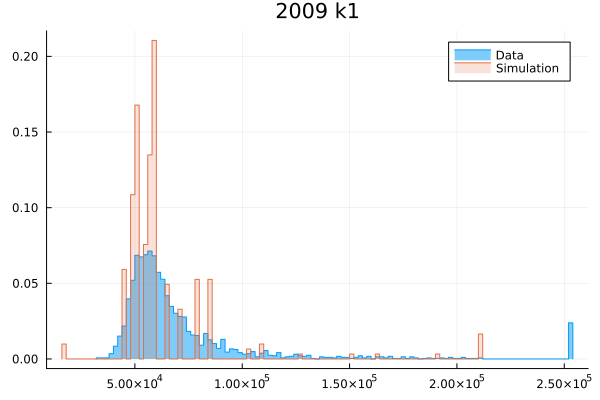

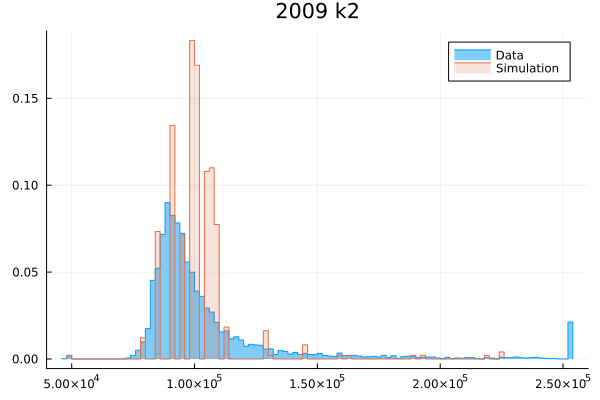

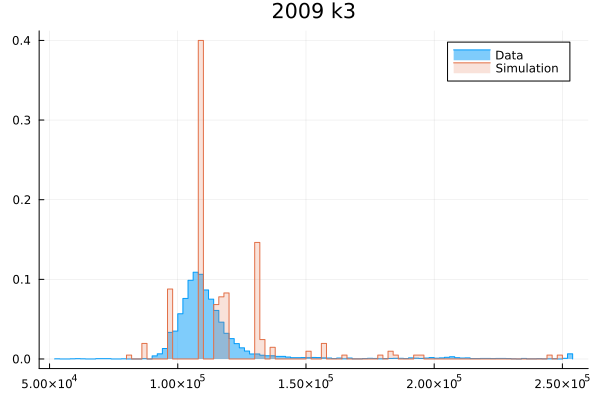

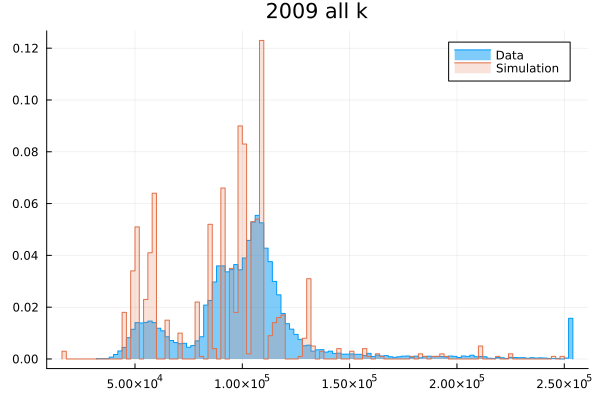

In [15]:
# plotting the matches

# Year 2009
stephist(m_observed_true[1:s_k1_1_d1,1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2009 k1")
display(stephist!(m_P_hat_1[tempk1y1].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(s_k1_1_d1+1):(s_k1_1_d1+s_k2_1_d1),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2009 k2")
display(stephist!(m_P_hat_1[tempk2y1].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(s_k1_1_d1+s_k2_1_d1+1):ssk_1,1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2009 k3")
display(stephist!(m_P_hat_1[tempk3y1].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[1:ssk_1,1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2009 all k")
display(stephist!(m_P_hat_1.*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

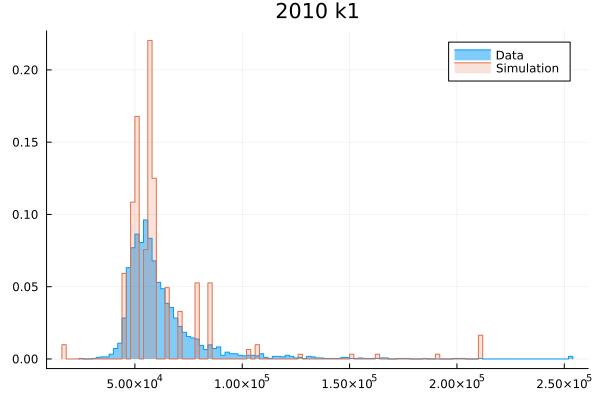

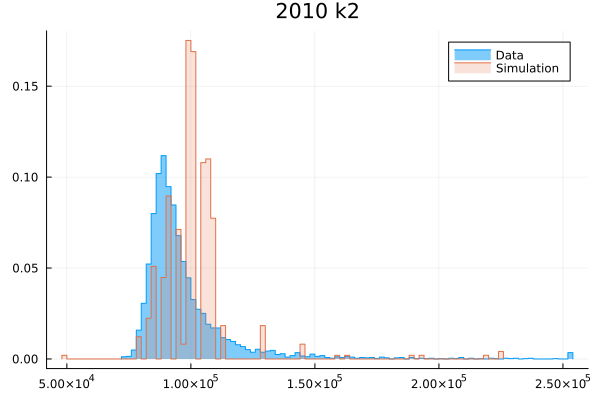

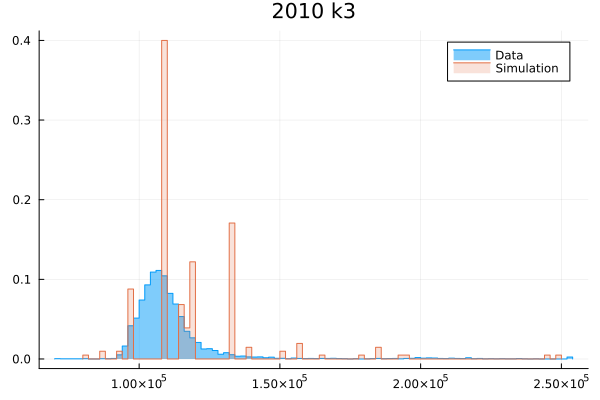

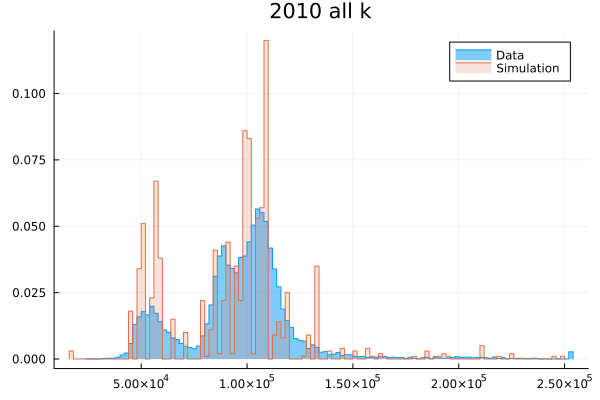

In [16]:
# plotting the matches

# Year 2010
stephist(m_observed_true[(ssk_1+1):(ssk_1+s_k1_2_d1),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2010 k1")
display(stephist!(m_P_hat_2[tempk1y2].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(ssk_1+s_k1_2_d1+1):(ssk_1+s_k1_2_d1+s_k2_2_d1),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2010 k2")
display(stephist!(m_P_hat_2[tempk2y2].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(ssk_1+s_k1_2_d1+s_k2_2_d1+1):(ssk_1+s_k1_2_d1+s_k2_2_d1+s_k3_2_d1),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2010 k3")
display(stephist!(m_P_hat_2[tempk3y2].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(ssk_1+1):(ssk_1+ssk_2),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2010 all k")
display(stephist!(m_P_hat_2.*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

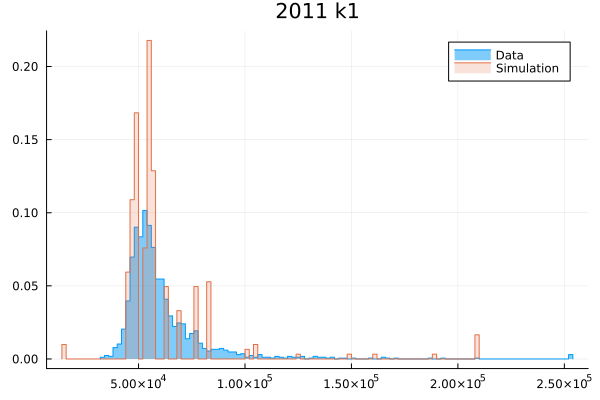

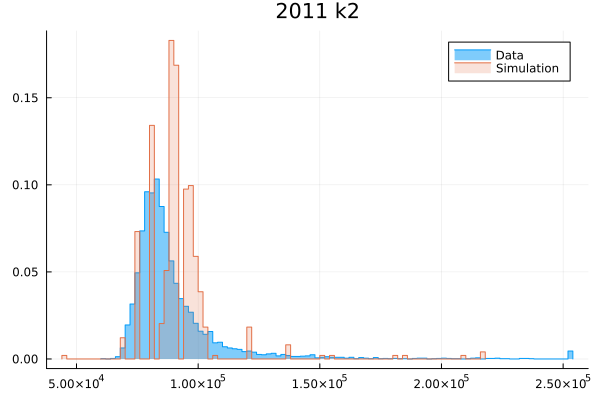

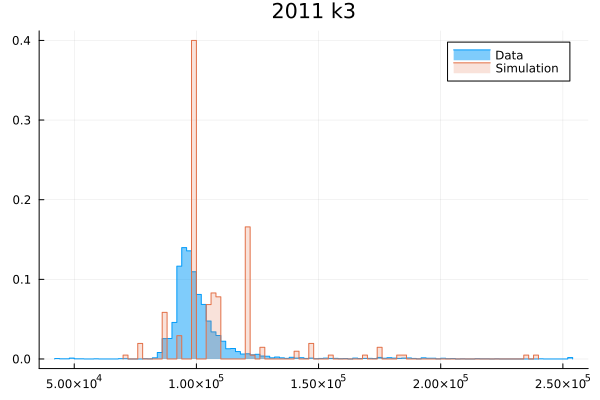

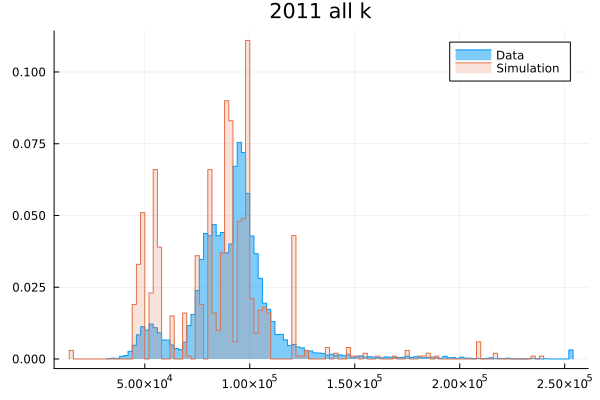

In [17]:
# plotting the matches

# Year 2010
stephist(m_observed_true[(ssk_1+ssk_2+1):(ssk_1+ssk_2+s_k1_3_d1),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2011 k1")
display(stephist!(m_P_hat_3[tempk1y3].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(ssk_1+ssk_2+s_k1_3_d1+1):(ssk_1+ssk_2+s_k1_3_d1+s_k2_3_d1),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2011 k2")
display(stephist!(m_P_hat_3[tempk2y3].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(ssk_1+ssk_2+s_k1_3_d1+s_k2_3_d1+1):(ssk_1+ssk_2+s_k1_3_d1+s_k2_3_d1+s_k3_3_d1),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2011 k3")
display(stephist!(m_P_hat_3[tempk3y3].*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

stephist(m_observed_true[(ssk_1+ssk_2+1):(ssk_1+ssk_2+ssk_3),1],normalize =:probability, fill=true, fillalpha=0.5,label = "Data",nbins = 150, title = "2011 all k")
display(stephist!(m_P_hat_3.*scale,normalize =:probability, fill=true, fillalpha=0.2,label= "Simulation",nbins = 150))

In [55]:
const n=2
y=rand(n)
x=rand(n)
z=rand(n,n)
c=ones(2)
d=ones(2)
f=ones(2,2)
g=zeros(2,2)
size(mul!(c,f,d))
g*f


2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

In [33]:
print(d)
print(c)

[1.0, 1.0][2.0, 2.0]

In [5]:
v=ones(3)
print(v,v')
print(size(v),size(v'),typeof(v))

[1.0, 1.0, 1.0][1.0 1.0 1.0](3,)(1, 3)Vector{Float64}

In [54]:
c=59
g=5
m=c./g/sum(c+g)
print(m)


0.184375

In [72]:
ee=[1,2,3]
dd=[1,2,3]
ee.*dd

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 4

In [2]:
d=zeros(2,2)
e=ones(2,2)
f=ones(2,2)
mul!(d,e,f)
print(e.*f)

[1.0 1.0; 1.0 1.0]

LoadError: UndefVarError: type not defined

In [12]:
function Strassen(A, B)
    n = size(A, 1)
    if n == 1
        return A * B
    end
    @views A11 = A[1:n÷2, 1:n÷2]
    @views A12 = A[1:n÷2, n÷2+1:n]
    @views A21 = A[n÷2+1:n, 1:n÷2]
    @views A22 = A[n÷2+1:n, n÷2+1:n]
    @views B11 = B[1:n÷2, 1:n÷2]
    @views B12 = B[1:n÷2, n÷2+1:n]
    @views B21 = B[n÷2+1:n, 1:n÷2]
    @views B22 = B[n÷2+1:n, n÷2+1:n]

    P1 = Strassen(A12 - A22, B21 + B22)
    P2 = Strassen(A11 + A22, B11 + B22)
    P3 = Strassen(A11 - A21, B11 + B12)
    P4 = Strassen(A11 + A12, B22)
    P5 = Strassen(A11, B12 - B22)
    P6 = Strassen(A22, B21 - B11)
    P7 = Strassen(A21 + A22, B11)

    C11 = P1 + P2 - P4 + P6
    C12 = P4 + P5
    C21 = P6 + P7
    C22 = P2 - P3 + P5 - P7

    return [C11 C12; C21 C22]
end


Strassen (generic function with 1 method)

In [13]:
# check for convergence
f_mo_hat = ones(1,nS)/nS;
g            = (1/3) * (1/10) * ones(1,nS); #Density particles are drawn from;
diff_v       = 99;
w            = zeros(1,nS);

println("checking convergence ......")
@time for itera in 1:max_iter
    
    f_mo_hat_new=copy(f_mo_hat);
    global w = f_mo_hat_new./g / sum(f_mo_hat_new./g);
    tempC = similar(fdensity);
    mul!(tempC,ones(num_obs,1),f_mo_hat_new)
    temptop = (tempC.*fdensity);
    mul!(tempC,ones(num_obs,1),w)
    tempbottom = (sum(tempC.*fdensity,dims=2)*ones(1,nS));
    temp_a  = findall(x-> x==0,tempbottom); 
    #temp_max = 10*maximum(tempbottom);
    #tempbottom[temp_a] .= temp_max;
    #temp_min = 0.01*minimum(tempbottom);
    #tempbottom[temp_a] .= temp_min;
    tempbottom[temp_a] .= 0.0001;
    global f_mo_hat = mean( temptop./ tempbottom, dims = 1);
    global diff_v = maximum(abs.(f_mo_hat_new-f_mo_hat));
    
    if (itera/10)==round(itera/10)&&(diff_v>tol)
        println("iter = $itera, diff = $diff_v")
    end

    if(diff_v<=tol)   
        println("iter = $itera, diff = $diff_v")
        break
    end

end

checking convergence ......
iter = 10, diff = 0.0031268894961146154
iter = 20, diff = 0.0019989025521717357
iter = 30, diff = 0.001278028769663559
iter = 36, diff = 0.0009769840433304436
  3.716939 seconds (496.72 k allocations: 5.693 GiB, 13.36% gc time, 4.49% compilation time)


In [14]:
# check for convergence
f_mo_hat = ones(1,nS)/nS;
g            = (1/3) * (1/10) * ones(1,nS); #Density particles are drawn from;
diff_v       = 99;
w            = zeros(1,nS);

println("checking convergence ......")
@time for itera in 1:max_iter
    
    f_mo_hat_new=copy(f_mo_hat);
    global w = f_mo_hat_new./g / sum(f_mo_hat_new./g);
    tempC = similar(fdensity);
    tempC=Strassen(ones(num_obs,1), f_mo_hat_new)
    temptop = (tempC.*fdensity);
    tempC=Strassen(ones(num_obs,1), w)
    tempbottom = (sum(tempC.*fdensity,dims=2)*ones(1,nS));
    temp_a  = findall(x-> x==0,tempbottom); 
    #temp_max = 10*maximum(tempbottom);
    #tempbottom[temp_a] .= temp_max;
    #temp_min = 0.01*minimum(tempbottom);
    #tempbottom[temp_a] .= temp_min;
    tempbottom[temp_a] .= 0.0001;
    global f_mo_hat = mean( temptop./ tempbottom, dims = 1);
    global diff_v = maximum(abs.(f_mo_hat_new-f_mo_hat));
    
    if (itera/10)==round(itera/10)&&(diff_v>tol)
        println("iter = $itera, diff = $diff_v")
    end

    if(diff_v<=tol)   
        println("iter = $itera, diff = $diff_v")
        break
    end

end

checking convergence ......


LoadError: BoundsError: attempt to access 41183×1 Matrix{Float64} at index [1:20591, 1:20591]

LoadError: syntax: unexpected semicolon in array expression around In[21]:1

In [4]:
for i = 1 : 3
for j = 2 : 5
print("($i,$j) ")
end
println()
end

(1,2) (1,3) (1,4) (1,5) 
(2,2) (2,3) (2,4) (2,5) 
(3,2) (3,3) (3,4) (3,5) 


In [ ]:
x=[[1,2;3,4],[3,4;1,2]]
print(typeof(x))

In [ ]:
A = Array{Float64, 2}(undef, 2, 3)
print(typeof(A))